In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
MODEL_NAME = "Qwen/Qwen2.5-7B-Instruct"

DATA_PATHS = {
    "llama8b_inf_full_vall_full": 
        'results-squad-llama3-8b-instruct.jsonl',
    "llama8b_inf_full_val_awq_int4": 
        'results-squad-llama3-8b-instruct-inf_full-val_awq_int4.jsonl',
    "llama8b_inf_awq_int4_val_full": 
        'results-squad-llama3-8b-instruct-inf_awq_int4_val_full.jsonl',
    "llama8b_inf_awq_int8_val_full": 
        'results-squad-llama3-8b-instruct-inf_awq_int8_val_full.jsonl',
    "llama8b_inf_awq_int8_val_full_v2": 
        'results-squad-llama3-8b-instruct-inf_awq_int8_val_full_v2.jsonl',
    "llama8b_inf_full_val_full_v2": 
        'results-squad-llama3-8b-instruct_v2.jsonl',
    "llama8b_with_context_inf_full_val_int8": 
        "squad-all_context_2000output_inf-full_val-int8_first-6000.jsonl",
    
    "qwq_context_inf_full_val_fp8": 
        "squad-all_QWQ_context_2000output_inf-full_val-fp8.jsonl",

    "qwq_context_inf_full_val_full":
        "squad-all_QWQ_context_2000output_inf-full_val-full.jsonl",

    "qwq_context_inf_int4_val_int4":
        "squad-all_QWQ_context_2000output_inf-awq-int4_val-awq-int4.jsonl",

    "qwq_context_inf_int4_val_fp8":
        "squad-all_QWQ_context_2000output_inf-awq-int4_val-fp8.jsonl",
    "qwq_context_inf_fp8_val_fp8":
        "squad-all_QWQ_context_2000output_inf-fp8_val-fp8.jsonl",

    "qwq_context_inf_int4_val_fp8_UPDATED":
        'squad-all_QWQ_context_2000output_inf-awq-int4_val-fp8_UPDATED.jsonl',

    "qwen8b_fp8_val_fp8":
        "squad-all_qwen25-7B_fp8_val-fp8.jsonl",

    "qwen8b_int4_val_int4":
        "squad-all_qwen25-7B_awq-int4_val-fp8.jsonl",
    
}

from validation.data import (
    load_from_jsonl,
)

from validation.utils import distance, token_distance2, distance2
from validation import stats

In [14]:
import matplotlib.pyplot as plt


def process_data(items):
    distances = [
        distance2(item.inference_result, item.validation_result)
        for item in items
    ]


    top_k_matches_ratios = [d[1] for d in distances]
    distances = [d[0] for d in distances]


    def clean_data(items, distances, top_k_matches_ratios):
        """
        Fix case when tokens sequences don't match
        """
        original_len = len(items)
        drop_items = []
        for item, d in zip(items, distances):
            if d == -1:
                drop_items.append(item)
            
        items = [item for item in items if item not in drop_items]
        distances = [distance for distance in distances if distance != -1]
        top_k_matches_ratios = [ratio for ratio in top_k_matches_ratios if ratio != -1]
        print(f"Dropped {len(drop_items)} / {original_len} items")

        return items, distances, top_k_matches_ratios


    items, distances, top_k_matches_ratios = clean_data(items, distances, top_k_matches_ratios)
    return items, distances, top_k_matches_ratios



def analyze(distances, top_k_matches_ratios):
    stats.describe_data(distances, name="distances")
    stats.describe_data(top_k_matches_ratios, name="top_k_matches_ratios")
    best_fit, fit_results = stats.select_best_fit(distances)
    stats.plot_real_vs_fitted(distances, dist_name=best_fit.dist_name, bins=250)

    return best_fit, fit_results


def plot_distances_and_matches(items, distances, top_k_matches_ratios, title_prefix=""):
    """
    Plots two scatter plots side by side:
      1) Distances vs. # of tokens
      2) Top-K Matches Ratios vs. # of tokens
    """
    n_tokens = [len(item.inference_result.results) for item in items]
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.scatter(n_tokens, distances, alpha=0.3)
    plt.xlabel("Number of tokens")
    plt.ylabel("Distance")
    plt.title(f"{title_prefix} Distance vs. #tokens")

    plt.subplot(1, 2, 2)
    plt.scatter(n_tokens, top_k_matches_ratios, alpha=0.3, color="orange")
    plt.xlabel("Number of tokens")
    plt.ylabel("Top-K Matches Ratio")
    plt.title(f"{title_prefix} Top-K Matches Ratio vs. #tokens")
    
    plt.tight_layout()
    plt.show()





################################################################################
Analyzing llama8b_inf_full_vall_full : results-squad-llama3-8b-instruct.jsonl
Dropped 329 / 87599 items


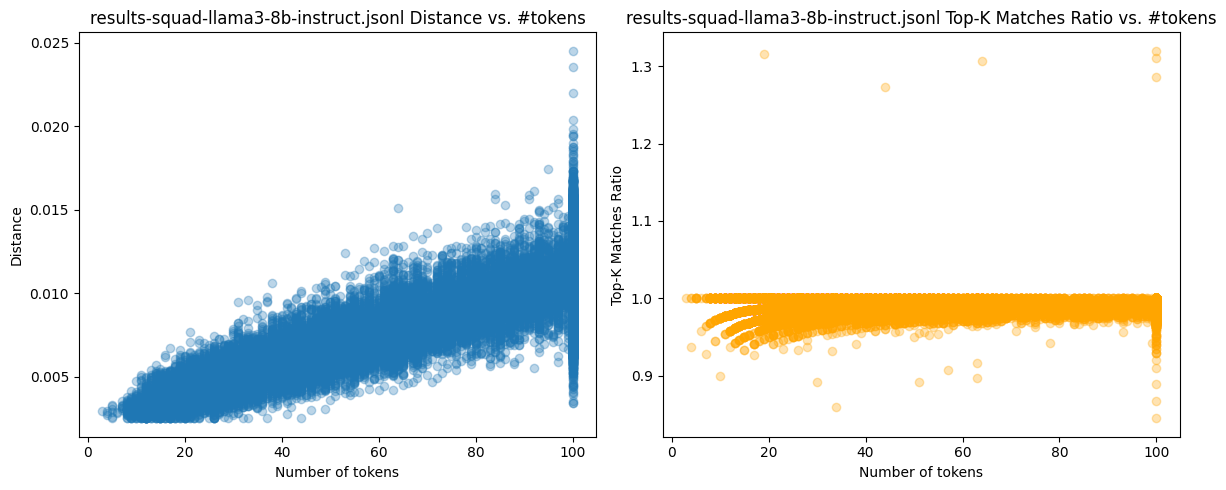


--- DISTANCES DESCRIPTIVE STATISTICS ---
Count: 87270
Min:   0.0025
Max:   0.0245
Mean:  0.0097
Std:   0.0026
Quartiles:
0.25    0.008480
0.50    0.010200
0.75    0.011428
dtype: float64

--- TOP_K_MATCHES_RATIOS DESCRIPTIVE STATISTICS ---
Count: 87270
Min:   0.8450
Max:   1.3200
Mean:  0.9902
Std:   0.0069
Quartiles:
0.25    0.9875
0.50    0.9900
0.75    0.9950
dtype: float64
################################################################################
Fitting normal...
Fitted Normal Params: mu=0.0097, sigma=0.0026
KS test: statistic=0.0962, p-value=0.0000
Fitting gamma...
Fitted Gamma Params: shape=11.0239, loc=0.0000, scale=0.0009
KS test: statistic=0.1422, p-value=0.0000
Fitting lognorm...
Fitted Lognormal Params: shape=0.3283, loc=0.0000, scale=0.0093
KS test: statistic=0.1631, p-value=0.0000
Fitting beta...
Fitted Beta Params: alpha=10.9435, beta=1117.7140, loc=0.0000, scale=1.0000
KS test: statistic=0.1418, p-value=0.0000
#####################################################

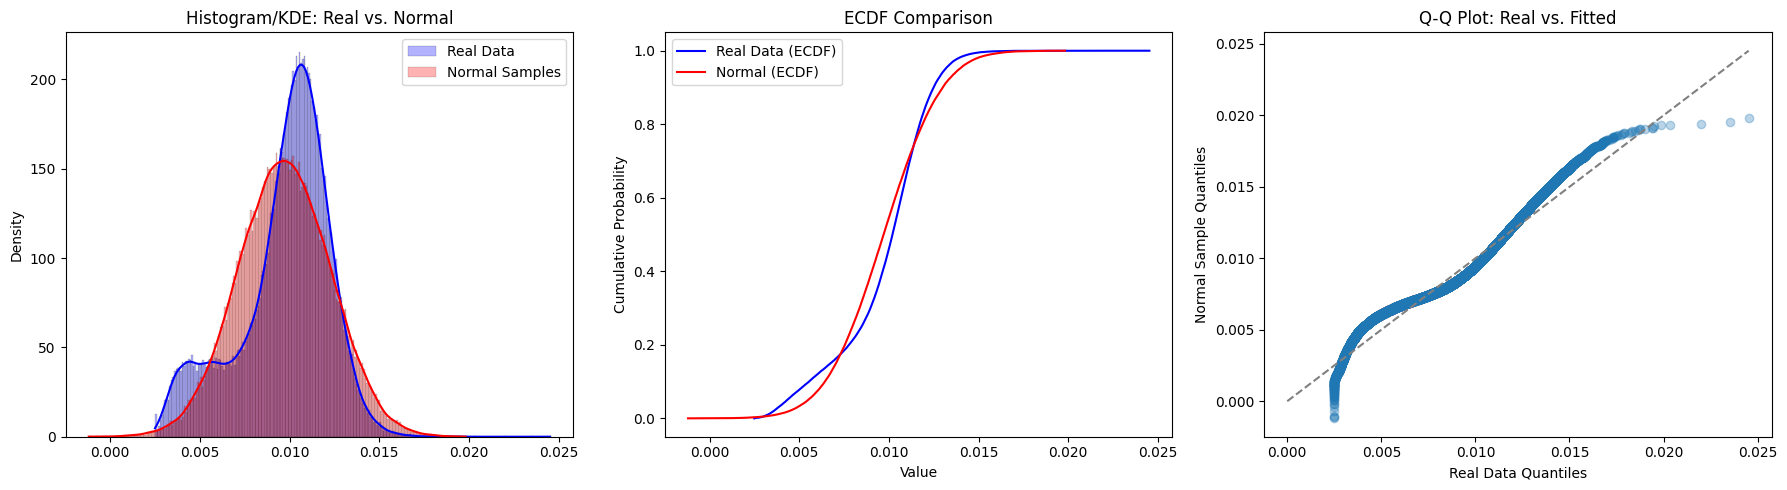




################################################################################
Analyzing llama8b_inf_full_val_awq_int4 : results-squad-llama3-8b-instruct-inf_full-val_awq_int4.jsonl
Dropped 15 / 5000 items


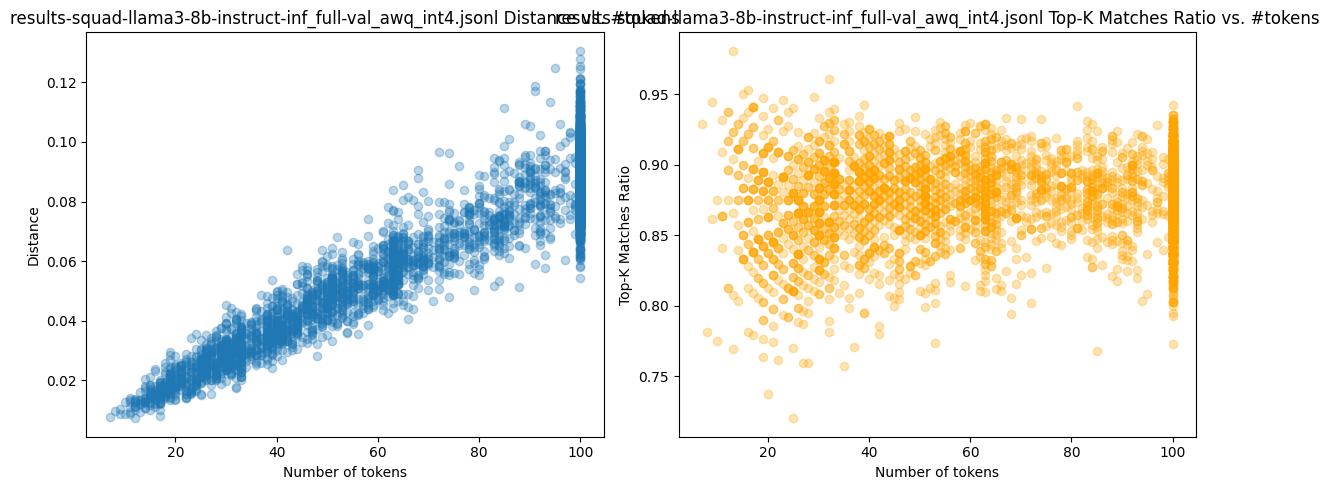


--- DISTANCES DESCRIPTIVE STATISTICS ---
Count: 4985
Min:   0.0072
Max:   0.1306
Mean:  0.0705
Std:   0.0256
Quartiles:
0.25    0.050668
0.50    0.079637
0.75    0.089881
dtype: float64

--- TOP_K_MATCHES_RATIOS DESCRIPTIVE STATISTICS ---
Count: 4985
Min:   0.7200
Max:   0.9808
Mean:  0.8781
Std:   0.0267
Quartiles:
0.25    0.862500
0.50    0.880435
0.75    0.896154
dtype: float64
################################################################################
Fitting normal...
Fitted Normal Params: mu=0.0705, sigma=0.0256
KS test: statistic=0.1463, p-value=0.0000
Fitting gamma...
Fitted Gamma Params: shape=5.2852, loc=0.0000, scale=0.0133
KS test: statistic=0.1849, p-value=0.0000
Fitting lognorm...
Fitted Lognormal Params: shape=0.4950, loc=0.0000, scale=0.0639
KS test: statistic=0.1999, p-value=0.0000
Fitting beta...
Fitted Beta Params: alpha=5.0385, beta=66.5914, loc=0.0000, scale=1.0000
KS test: statistic=0.1823, p-value=0.0000
#####################################################

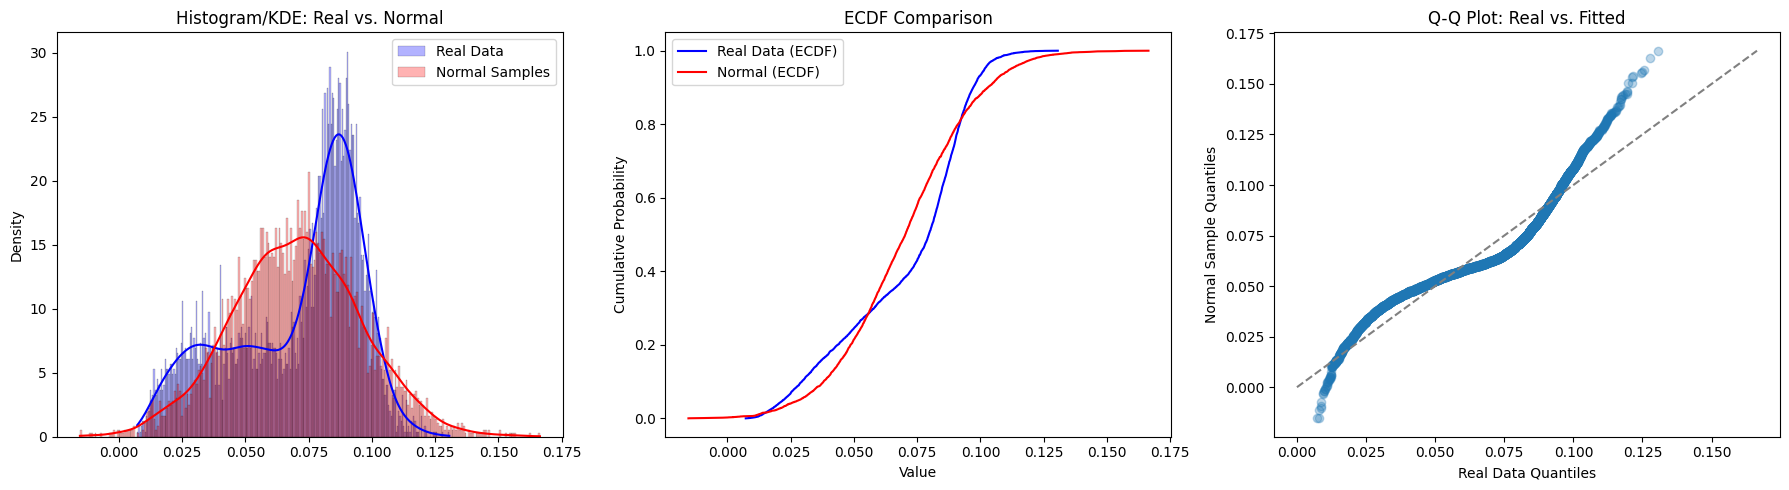




################################################################################
Analyzing llama8b_inf_awq_int4_val_full : results-squad-llama3-8b-instruct-inf_awq_int4_val_full.jsonl
Dropped 21 / 5000 items


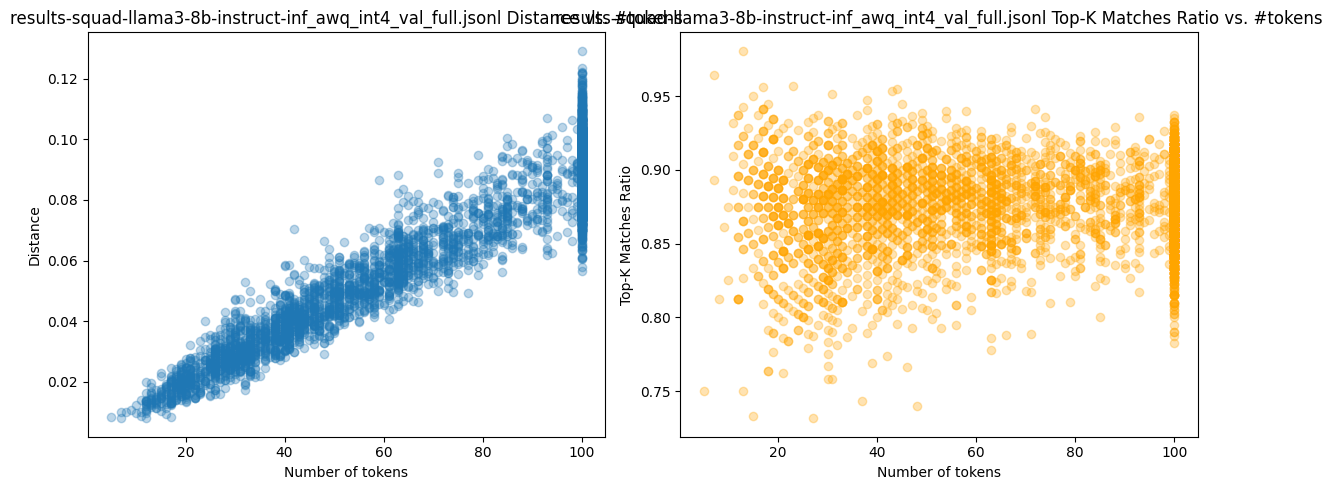


--- DISTANCES DESCRIPTIVE STATISTICS ---
Count: 4979
Min:   0.0079
Max:   0.1292
Mean:  0.0690
Std:   0.0260
Quartiles:
0.25    0.047360
0.50    0.077877
0.75    0.089327
dtype: float64

--- TOP_K_MATCHES_RATIOS DESCRIPTIVE STATISTICS ---
Count: 4979
Min:   0.7315
Max:   0.9808
Mean:  0.8772
Std:   0.0274
Quartiles:
0.25    0.862500
0.50    0.880000
0.75    0.895031
dtype: float64
################################################################################
Fitting normal...
Fitted Normal Params: mu=0.0690, sigma=0.0260
KS test: statistic=0.1358, p-value=0.0000
Fitting gamma...
Fitted Gamma Params: shape=5.1029, loc=0.0000, scale=0.0135
KS test: statistic=0.1748, p-value=0.0000
Fitting lognorm...
Fitted Lognormal Params: shape=0.4991, loc=0.0000, scale=0.0624
KS test: statistic=0.1883, p-value=0.0000
Fitting beta...
Fitted Beta Params: alpha=4.8614, beta=65.7125, loc=0.0000, scale=1.0000
KS test: statistic=0.1726, p-value=0.0000
#####################################################

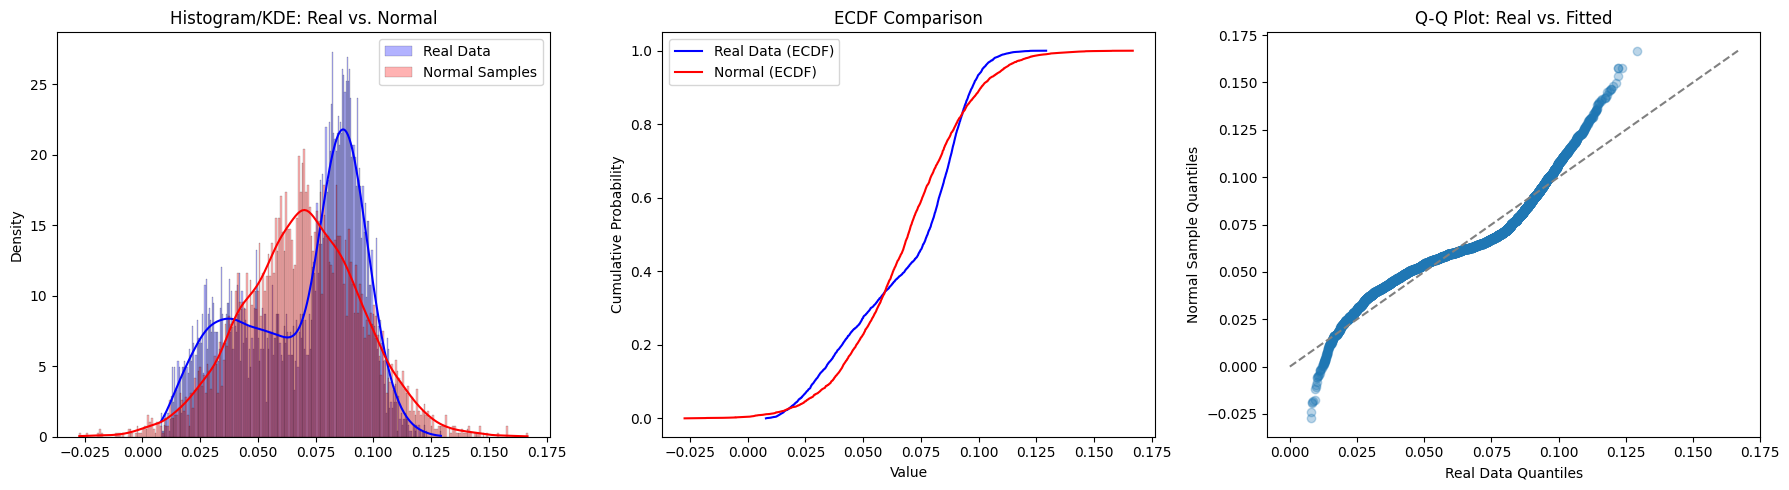




################################################################################
Analyzing llama8b_inf_awq_int8_val_full : results-squad-llama3-8b-instruct-inf_awq_int8_val_full.jsonl
Dropped 30 / 5000 items


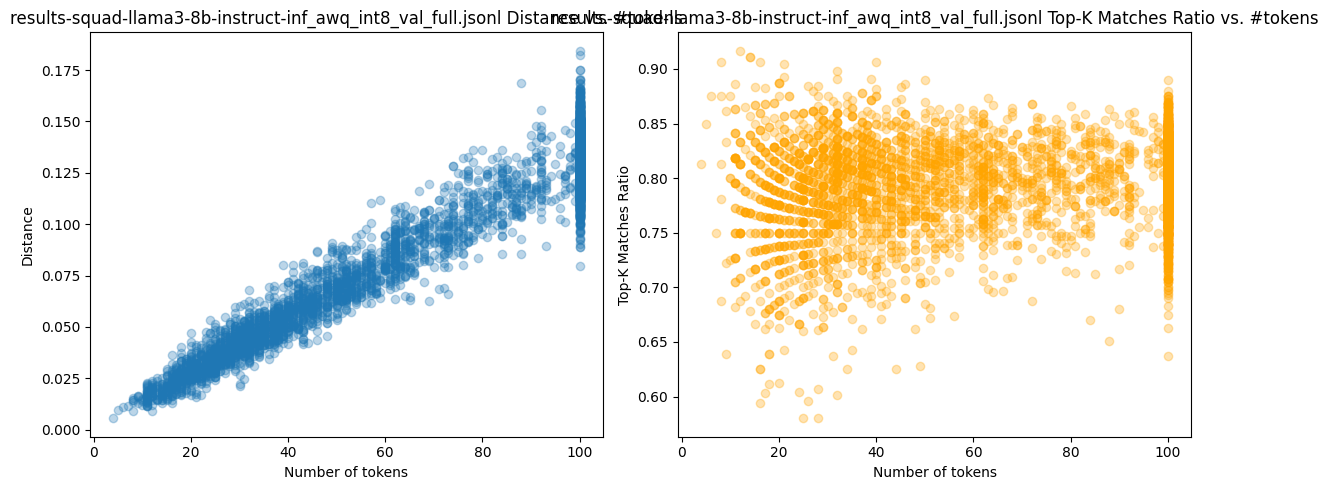


--- DISTANCES DESCRIPTIVE STATISTICS ---
Count: 4970
Min:   0.0055
Max:   0.1844
Mean:  0.0957
Std:   0.0418
Quartiles:
0.25    0.054753
0.50    0.112784
0.75    0.130696
dtype: float64

--- TOP_K_MATCHES_RATIOS DESCRIPTIVE STATISTICS ---
Count: 4970
Min:   0.5800
Max:   0.9167
Mean:  0.7955
Std:   0.0395
Quartiles:
0.25    0.774769
0.50    0.800000
0.75    0.821429
dtype: float64
################################################################################
Fitting normal...
Fitted Normal Params: mu=0.0957, sigma=0.0418
KS test: statistic=0.1612, p-value=0.0000
Fitting gamma...
Fitted Gamma Params: shape=3.7469, loc=0.0000, scale=0.0255
KS test: statistic=0.1918, p-value=0.0000
Fitting lognorm...
Fitted Lognormal Params: shape=0.5877, loc=0.0000, scale=0.0832
KS test: statistic=0.2000, p-value=0.0000
Fitting beta...
Fitted Beta Params: alpha=3.5067, beta=33.2890, loc=0.0000, scale=1.0000
KS test: statistic=0.1891, p-value=0.0000
#####################################################

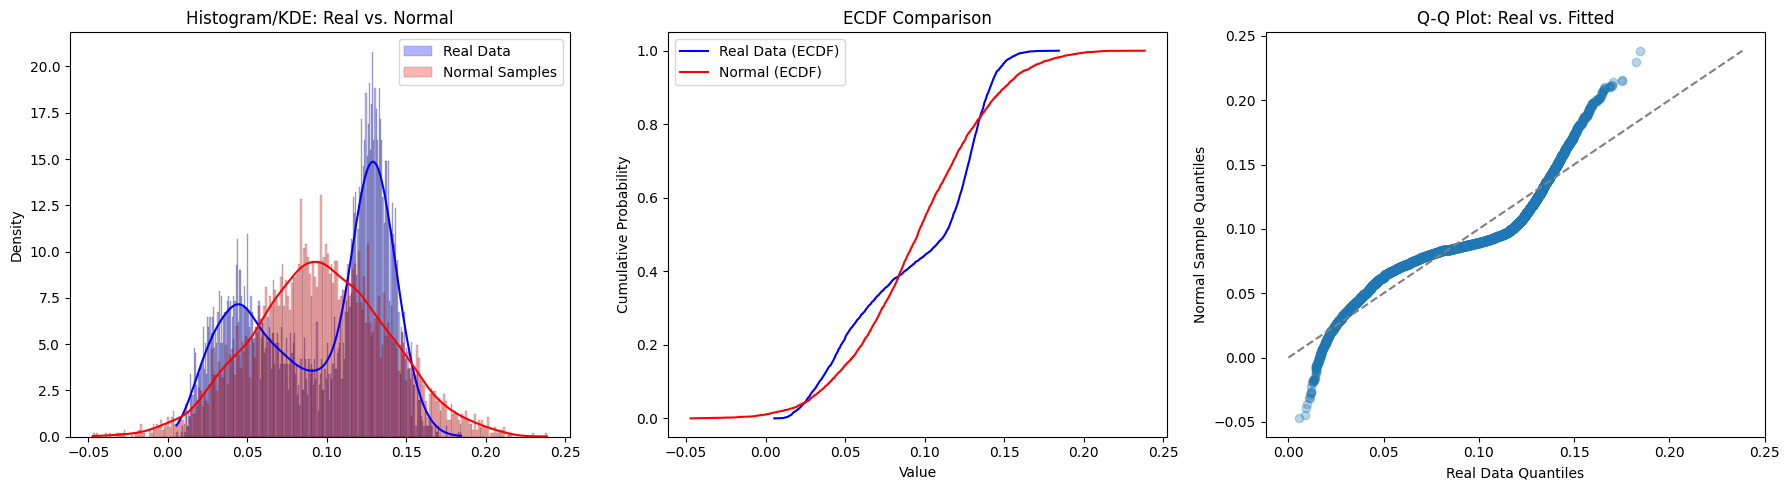




################################################################################
Analyzing llama8b_inf_awq_int8_val_full_v2 : results-squad-llama3-8b-instruct-inf_awq_int8_val_full_v2.jsonl
Dropped 292 / 5000 items


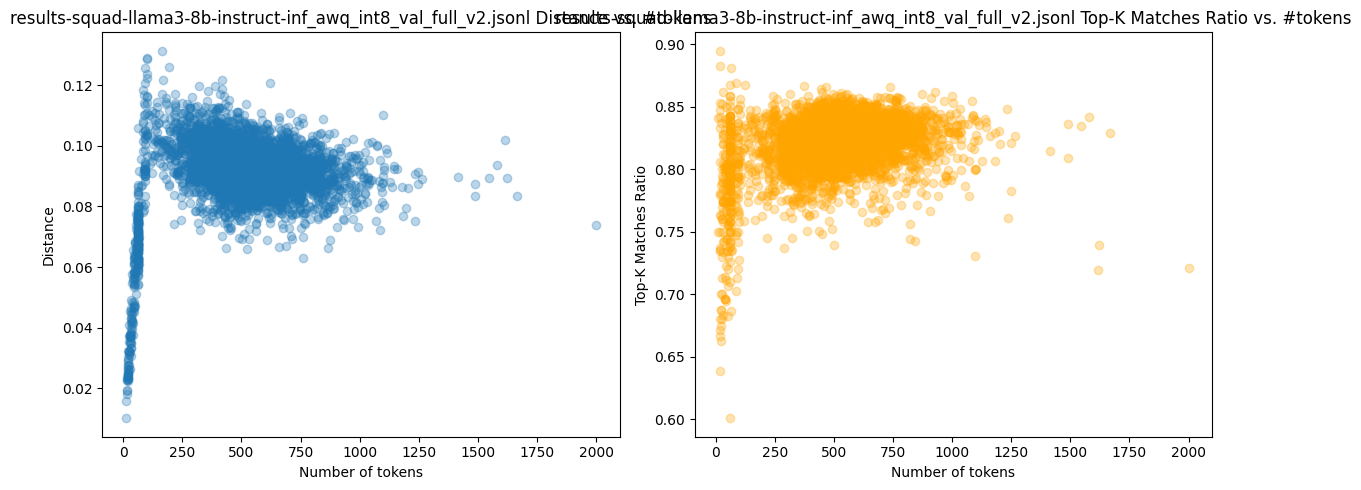


--- DISTANCES DESCRIPTIVE STATISTICS ---
Count: 4708
Min:   0.0101
Max:   0.1313
Mean:  0.0915
Std:   0.0117
Quartiles:
0.25    0.087784
0.50    0.092803
0.75    0.097664
dtype: float64

--- TOP_K_MATCHES_RATIOS DESCRIPTIVE STATISTICS ---
Count: 4708
Min:   0.6008
Max:   0.8947
Mean:  0.8205
Std:   0.0220
Quartiles:
0.25    0.811178
0.50    0.823610
0.75    0.834251
dtype: float64
################################################################################
Fitting normal...
Fitted Normal Params: mu=0.0915, sigma=0.0117
KS test: statistic=0.1345, p-value=0.0000
Fitting gamma...
Fitted Gamma Params: shape=42.6205, loc=0.0000, scale=0.0021
KS test: statistic=0.1788, p-value=0.0000
Fitting lognorm...
Fitted Lognormal Params: shape=0.1723, loc=0.0000, scale=0.0904
KS test: statistic=0.2008, p-value=0.0000
Fitting beta...
Fitted Beta Params: alpha=39.9105, beta=396.5242, loc=0.0000, scale=1.0000
KS test: statistic=0.1755, p-value=0.0000
##################################################

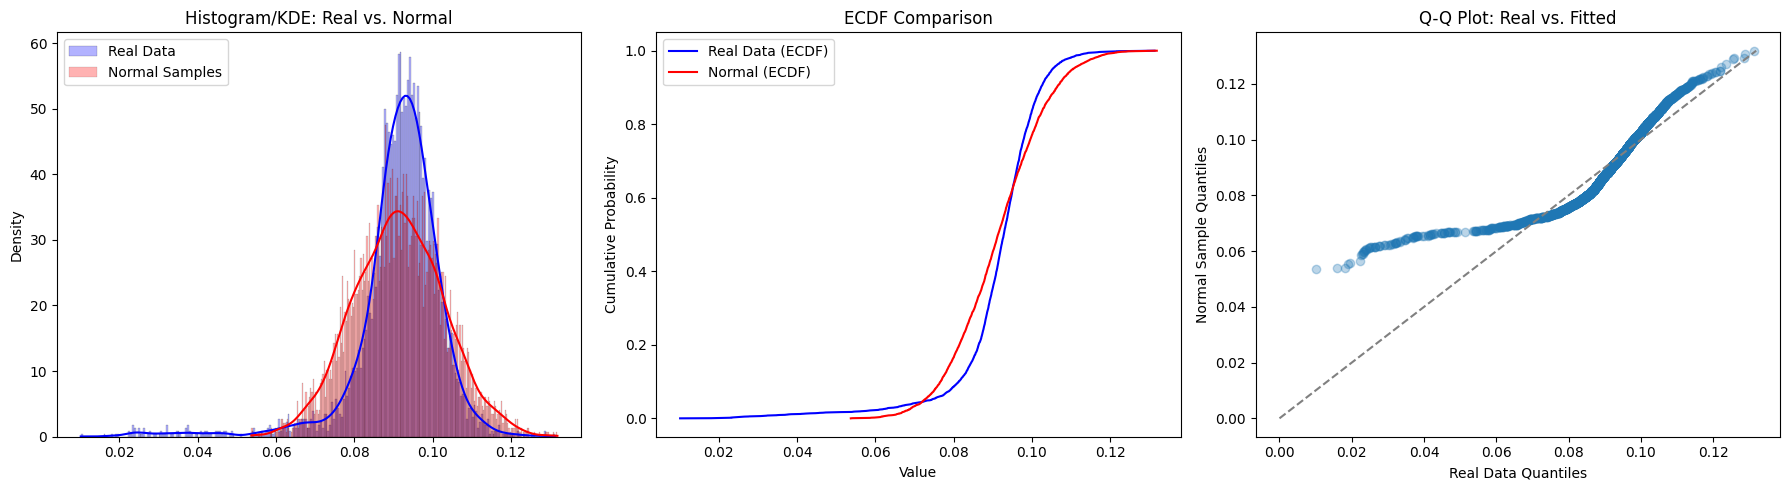




################################################################################
Analyzing llama8b_inf_full_val_full_v2 : results-squad-llama3-8b-instruct_v2.jsonl
Dropped 120 / 5000 items


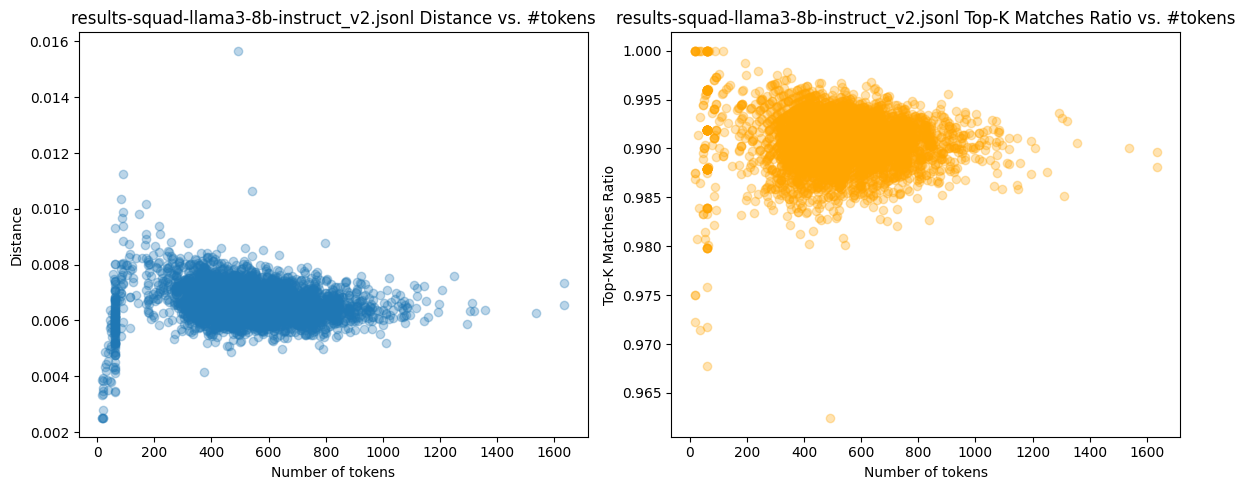


--- DISTANCES DESCRIPTIVE STATISTICS ---
Count: 4880
Min:   0.0025
Max:   0.0157
Mean:  0.0066
Std:   0.0006
Quartiles:
0.25    0.006287
0.50    0.006621
0.75    0.006981
dtype: float64

--- TOP_K_MATCHES_RATIOS DESCRIPTIVE STATISTICS ---
Count: 4880
Min:   0.9624
Max:   1.0000
Mean:  0.9906
Std:   0.0026
Quartiles:
0.25    0.989159
0.50    0.990757
0.75    0.992265
dtype: float64
################################################################################
Fitting normal...
Fitted Normal Params: mu=0.0066, sigma=0.0006
KS test: statistic=0.0474, p-value=0.0000
Fitting gamma...
Fitted Gamma Params: shape=109.3116, loc=0.0000, scale=0.0001
KS test: statistic=0.0523, p-value=0.0000
Fitting lognorm...
Fitted Lognormal Params: shape=0.0975, loc=0.0000, scale=0.0066
KS test: statistic=0.0578, p-value=0.0000
Fitting beta...
Fitted Beta Params: alpha=108.6101, beta=16243.6114, loc=0.0000, scale=1.0000
KS test: statistic=0.0523, p-value=0.0000
##############################################

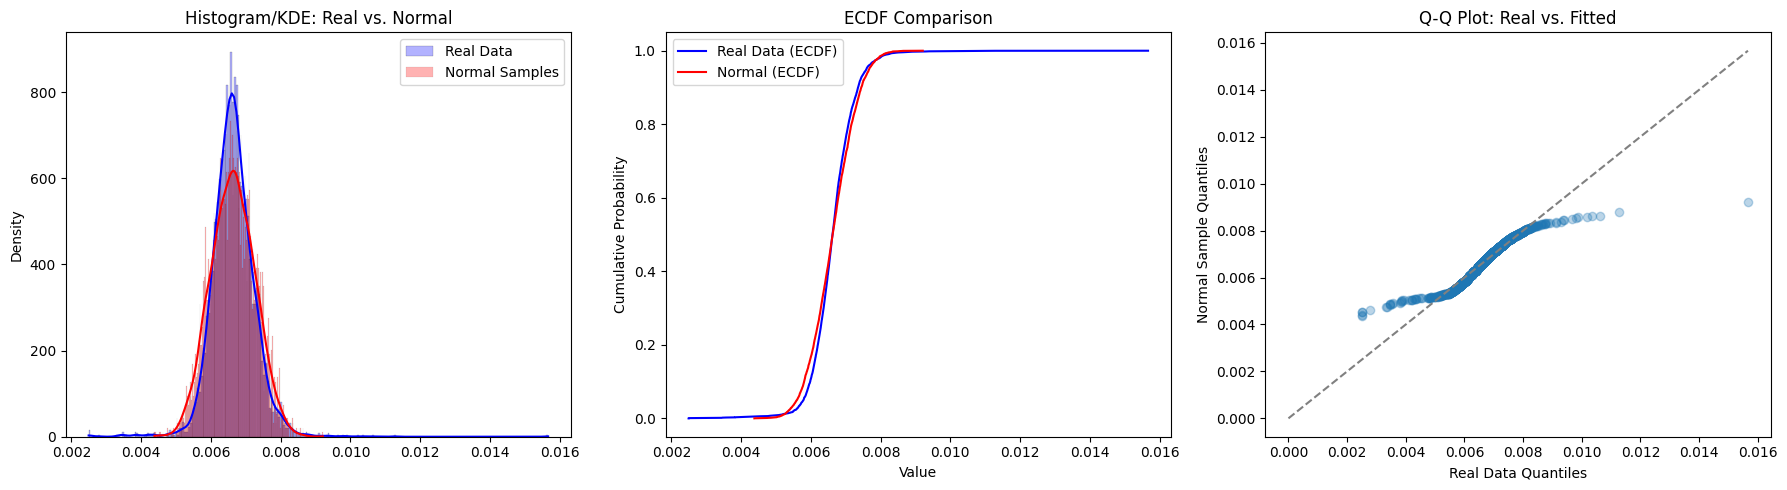




################################################################################
Analyzing llama8b_with_context_inf_full_val_int8 : squad-all_context_2000output_inf-full_val-int8_first-6000.jsonl
Dropped 78 / 6000 items


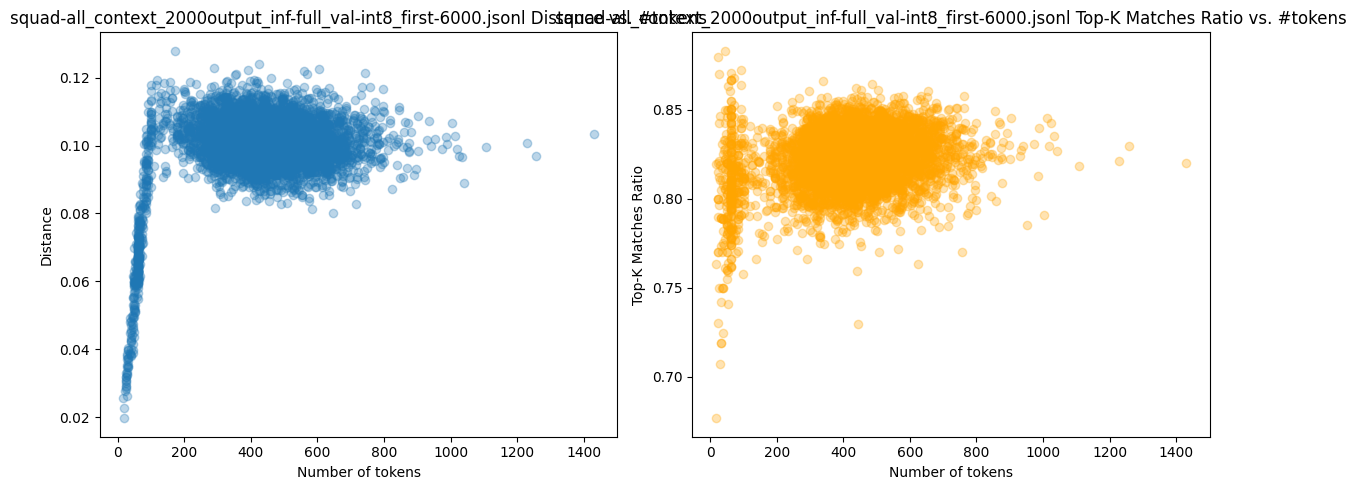


--- DISTANCES DESCRIPTIVE STATISTICS ---
Count: 5922
Min:   0.0197
Max:   0.1279
Mean:  0.0995
Std:   0.0107
Quartiles:
0.25    0.096591
0.50    0.100895
0.75    0.104995
dtype: float64

--- TOP_K_MATCHES_RATIOS DESCRIPTIVE STATISTICS ---
Count: 5922
Min:   0.6765
Max:   0.8833
Mean:  0.8227
Std:   0.0157
Quartiles:
0.25    0.814046
0.50    0.824074
0.75    0.833107
dtype: float64
################################################################################
Fitting normal...
Fitted Normal Params: mu=0.0995, sigma=0.0107
KS test: statistic=0.1645, p-value=0.0000
Fitting gamma...
Fitted Gamma Params: shape=61.8011, loc=0.0000, scale=0.0016
KS test: statistic=0.2048, p-value=0.0000
Fitting lognorm...
Fitted Lognormal Params: shape=0.1404, loc=0.0000, scale=0.0987
KS test: statistic=0.2245, p-value=0.0000
Fitting beta...
Fitted Beta Params: alpha=57.3752, beta=519.4773, loc=0.0000, scale=1.0000
KS test: statistic=0.2015, p-value=0.0000
##################################################

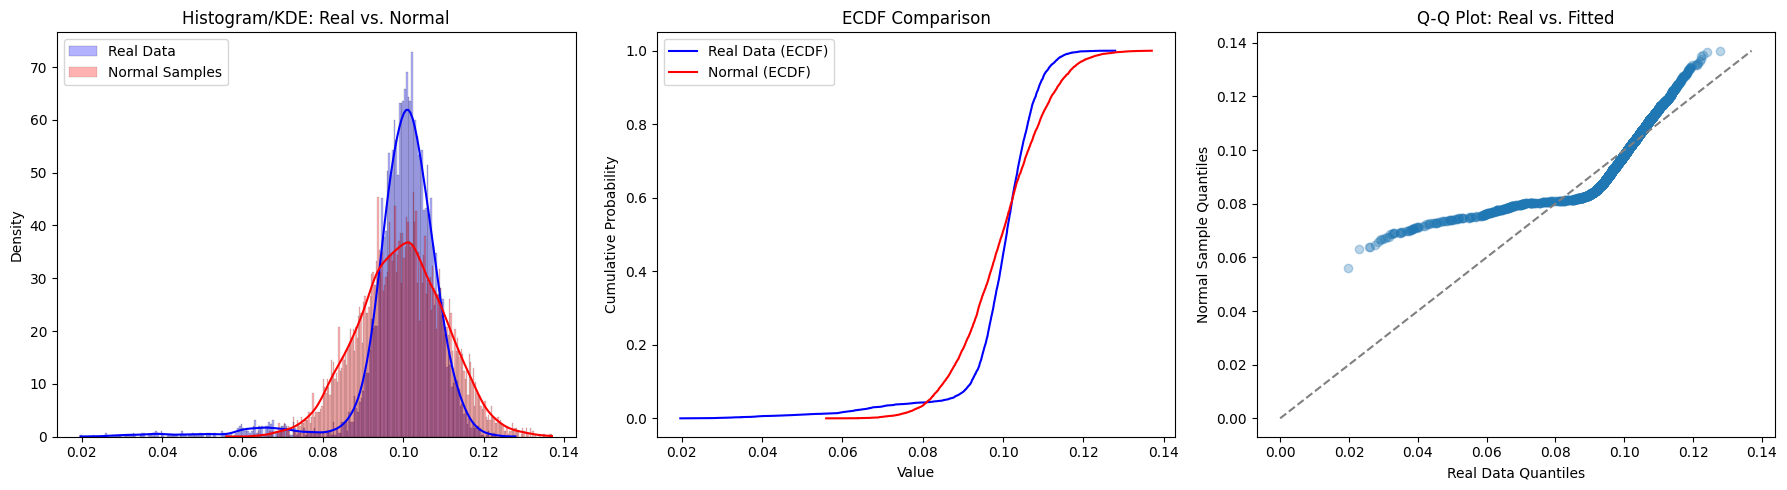




################################################################################
Analyzing qwq_context_inf_full_val_fp8 : squad-all_QWQ_context_2000output_inf-full_val-fp8.jsonl
Dropped 72 / 1000 items


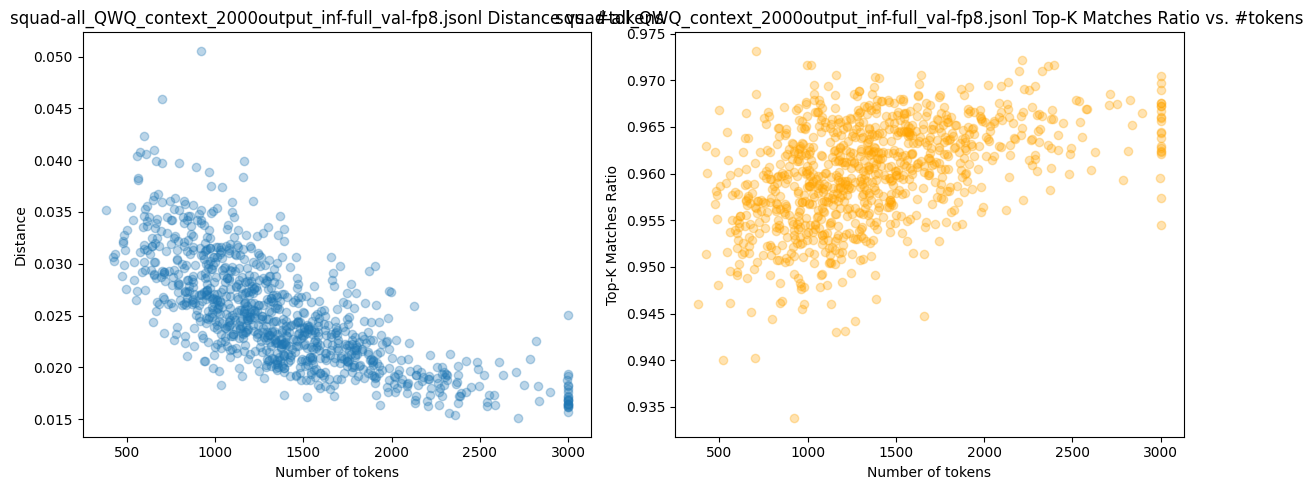


--- DISTANCES DESCRIPTIVE STATISTICS ---
Count: 928
Min:   0.0151
Max:   0.0506
Mean:  0.0251
Std:   0.0052
Quartiles:
0.25    0.021171
0.50    0.024449
0.75    0.028461
dtype: float64

--- TOP_K_MATCHES_RATIOS DESCRIPTIVE STATISTICS ---
Count: 928
Min:   0.9338
Max:   0.9732
Mean:  0.9601
Std:   0.0056
Quartiles:
0.25    0.956376
0.50    0.960519
0.75    0.964368
dtype: float64
################################################################################
Fitting normal...
Fitted Normal Params: mu=0.0251, sigma=0.0052
KS test: statistic=0.0599, p-value=0.0025
Fitting gamma...
Fitted Gamma Params: shape=24.2227, loc=0.0000, scale=0.0010
KS test: statistic=0.0379, p-value=0.1359
Fitting lognorm...
Fitted Lognormal Params: shape=0.2030, loc=0.0000, scale=0.0246
KS test: statistic=0.0265, p-value=0.5218
Fitting beta...
Fitted Beta Params: alpha=23.5961, beta=914.7290, loc=0.0000, scale=1.0000
KS test: statistic=0.0384, p-value=0.1256
####################################################

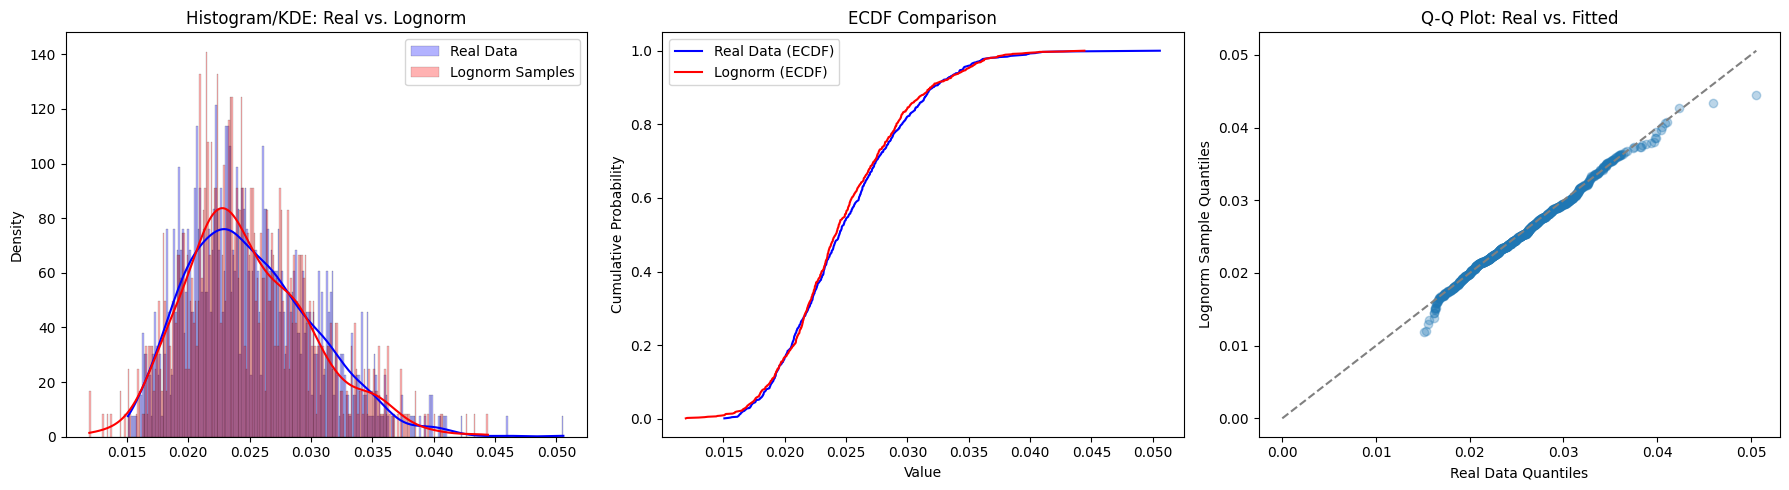




################################################################################
Analyzing qwq_context_inf_full_val_full : squad-all_QWQ_context_2000output_inf-full_val-full.jsonl
Dropped 95 / 1000 items


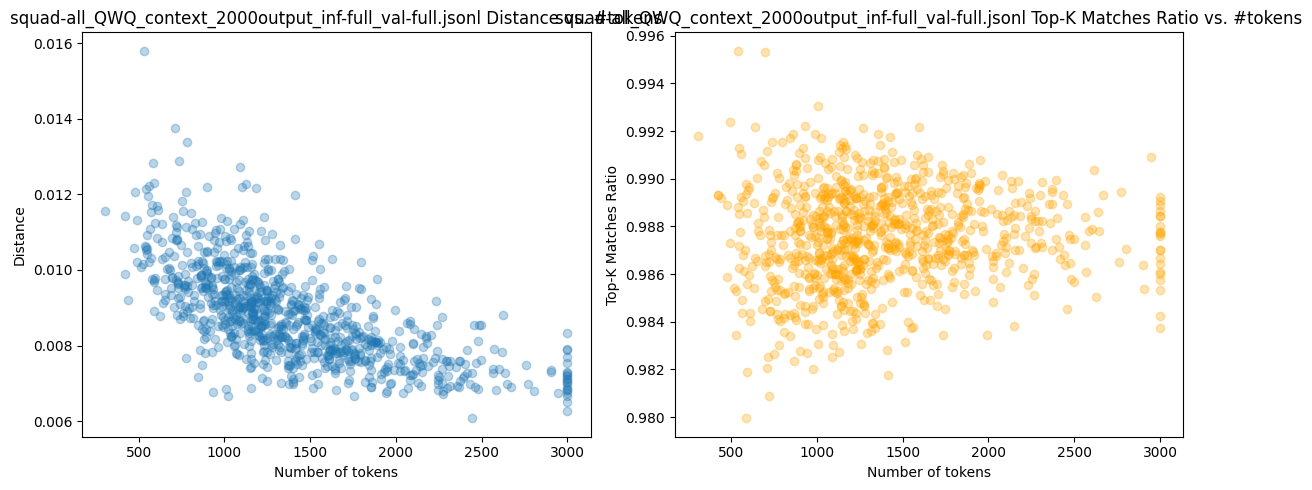


--- DISTANCES DESCRIPTIVE STATISTICS ---
Count: 905
Min:   0.0061
Max:   0.0158
Mean:  0.0088
Std:   0.0012
Quartiles:
0.25    0.007878
0.50    0.008666
0.75    0.009550
dtype: float64

--- TOP_K_MATCHES_RATIOS DESCRIPTIVE STATISTICS ---
Count: 905
Min:   0.9799
Max:   0.9954
Mean:  0.9876
Std:   0.0020
Quartiles:
0.25    0.986256
0.50    0.987631
0.75    0.989041
dtype: float64
################################################################################
Fitting normal...
Fitted Normal Params: mu=0.0088, sigma=0.0012
KS test: statistic=0.0480, p-value=0.0299
Fitting gamma...
Fitted Gamma Params: shape=52.0854, loc=0.0000, scale=0.0002
KS test: statistic=0.0378, p-value=0.1464
Fitting lognorm...
Fitted Lognormal Params: shape=0.1377, loc=0.0000, scale=0.0087
KS test: statistic=0.0319, p-value=0.3081
Fitting beta...
Fitted Beta Params: alpha=51.6095, beta=5807.8348, loc=0.0000, scale=1.0000
KS test: statistic=0.0379, p-value=0.1445
###################################################

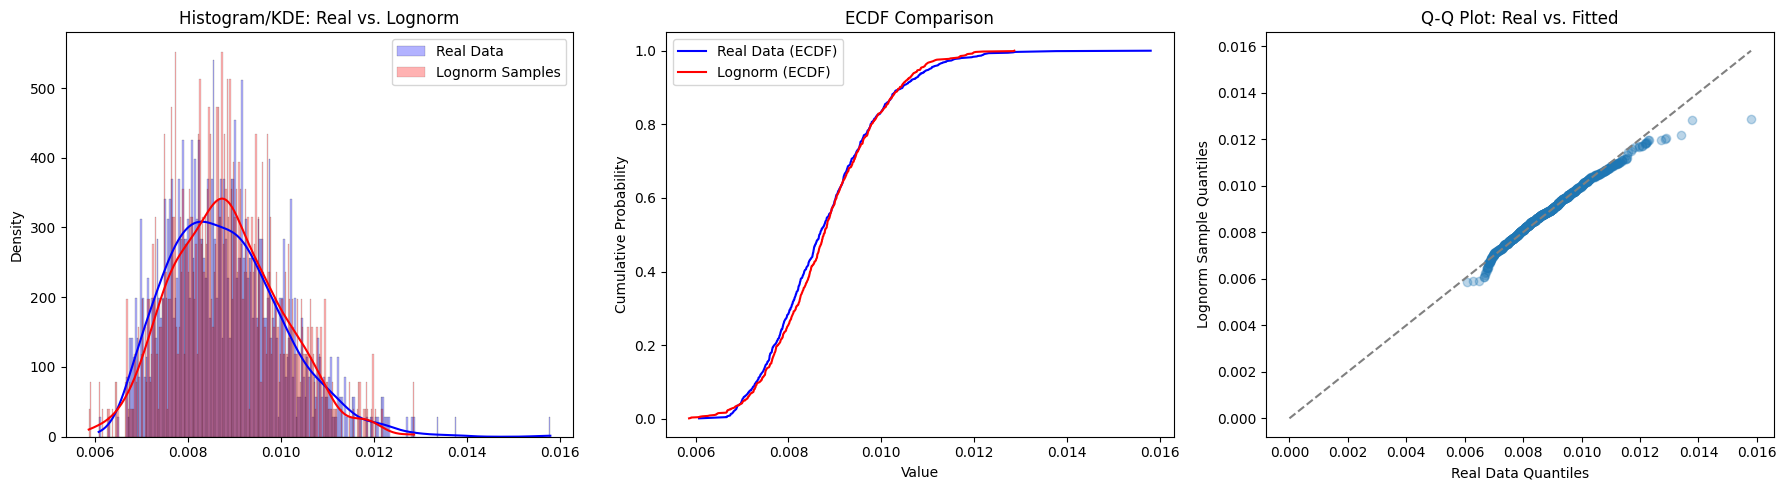




################################################################################
Analyzing qwq_context_inf_int4_val_int4 : squad-all_QWQ_context_2000output_inf-awq-int4_val-awq-int4.jsonl
Dropped 261 / 1800 items


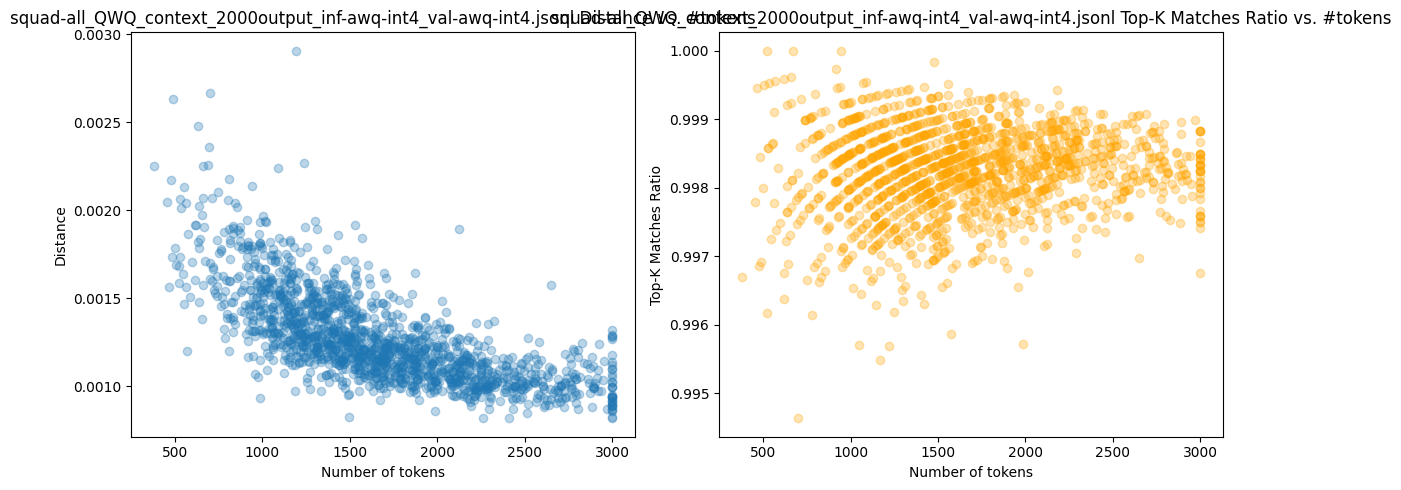


--- DISTANCES DESCRIPTIVE STATISTICS ---
Count: 1539
Min:   0.0008
Max:   0.0029
Mean:  0.0013
Std:   0.0003
Quartiles:
0.25    0.001084
0.50    0.001222
0.75    0.001418
dtype: float64

--- TOP_K_MATCHES_RATIOS DESCRIPTIVE STATISTICS ---
Count: 1539
Min:   0.9946
Max:   1.0000
Mean:  0.9982
Std:   0.0006
Quartiles:
0.25    0.997889
0.50    0.998321
0.75    0.998676
dtype: float64
################################################################################
Fitting normal...
Fitted Normal Params: mu=0.0013, sigma=0.0003
KS test: statistic=0.0941, p-value=0.0000
Fitting gamma...
Fitted Gamma Params: shape=26.3361, loc=0.0000, scale=0.0000
KS test: statistic=0.0692, p-value=0.0000
Fitting lognorm...
Fitted Lognormal Params: shape=0.1917, loc=0.0000, scale=0.0013
KS test: statistic=0.0568, p-value=0.0001
Fitting beta...
Fitted Beta Params: alpha=26.2992, beta=20595.7469, loc=0.0000, scale=1.0000
KS test: statistic=0.0693, p-value=0.0000
################################################

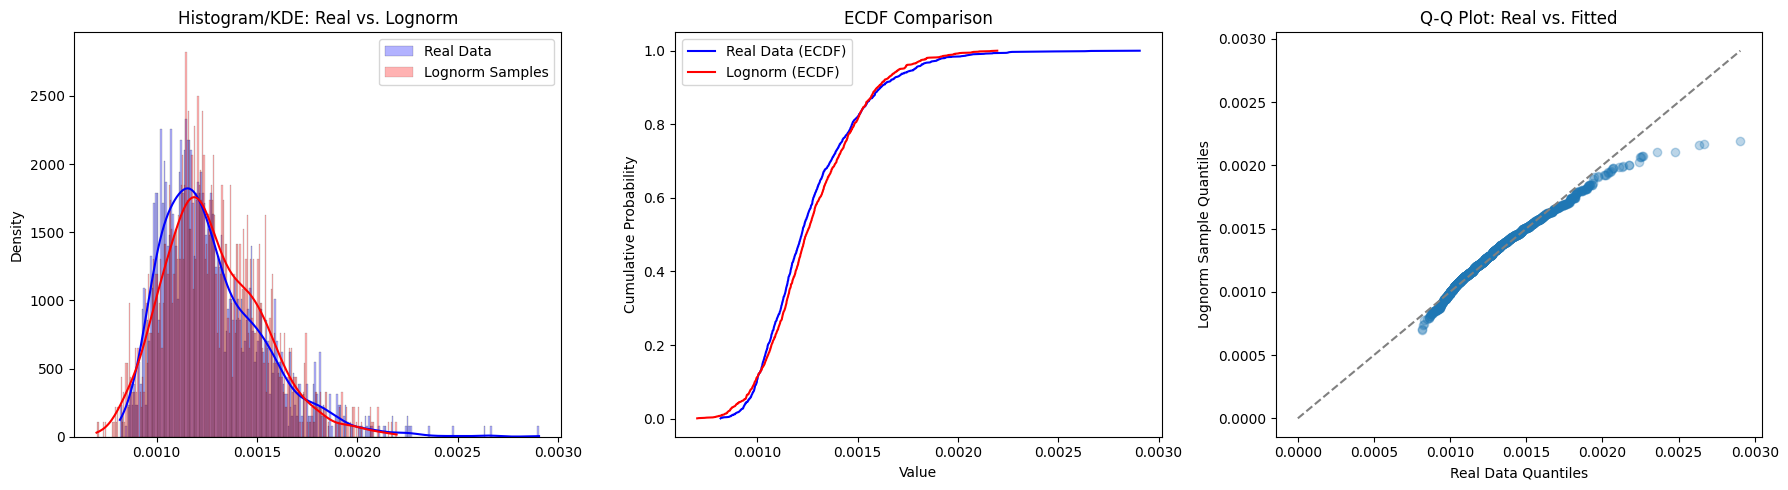




################################################################################
Analyzing qwq_context_inf_int4_val_fp8 : squad-all_QWQ_context_2000output_inf-awq-int4_val-fp8.jsonl
Dropped 323 / 3000 items


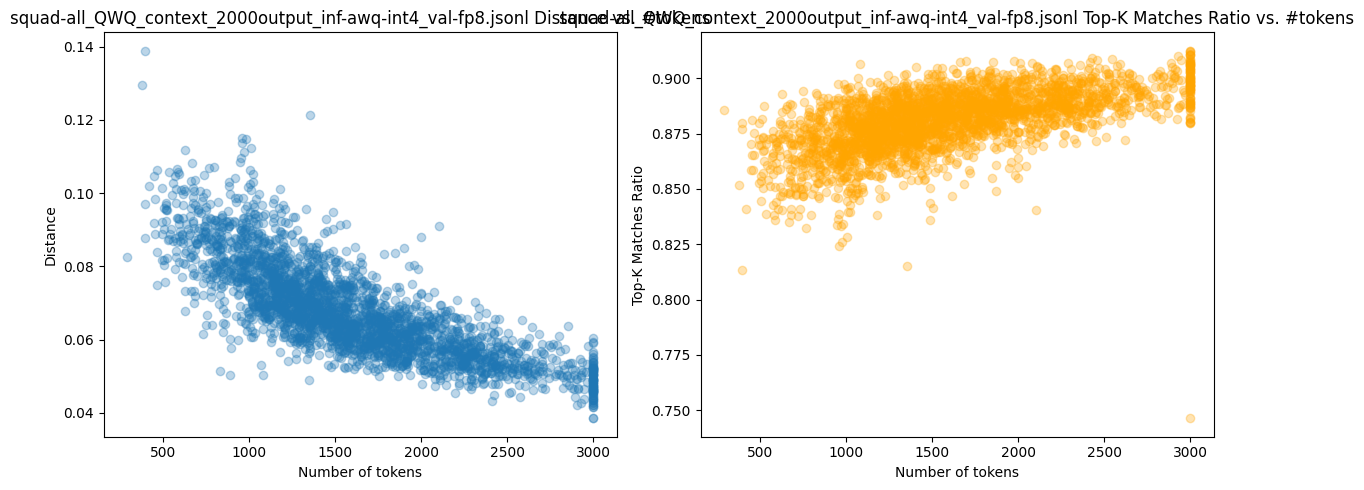


--- DISTANCES DESCRIPTIVE STATISTICS ---
Count: 2677
Min:   0.0385
Max:   0.1389
Mean:  0.0681
Std:   0.0130
Quartiles:
0.25    0.058500
0.50    0.066201
0.75    0.076054
dtype: float64

--- TOP_K_MATCHES_RATIOS DESCRIPTIVE STATISTICS ---
Count: 2677
Min:   0.7463
Max:   0.9124
Mean:  0.8807
Std:   0.0137
Quartiles:
0.25    0.872671
0.50    0.882381
0.75    0.889868
dtype: float64
################################################################################
Fitting normal...
Fitted Normal Params: mu=0.0681, sigma=0.0130
KS test: statistic=0.0613, p-value=0.0000
Fitting gamma...
Fitted Gamma Params: shape=28.6379, loc=0.0000, scale=0.0024
KS test: statistic=0.0379, p-value=0.0009
Fitting lognorm...
Fitted Lognormal Params: shape=0.1863, loc=0.0000, scale=0.0669
KS test: statistic=0.0267, p-value=0.0435
Fitting beta...
Fitted Beta Params: alpha=26.6187, beta=364.2701, loc=0.0000, scale=1.0000
KS test: statistic=0.0397, p-value=0.0004
##################################################

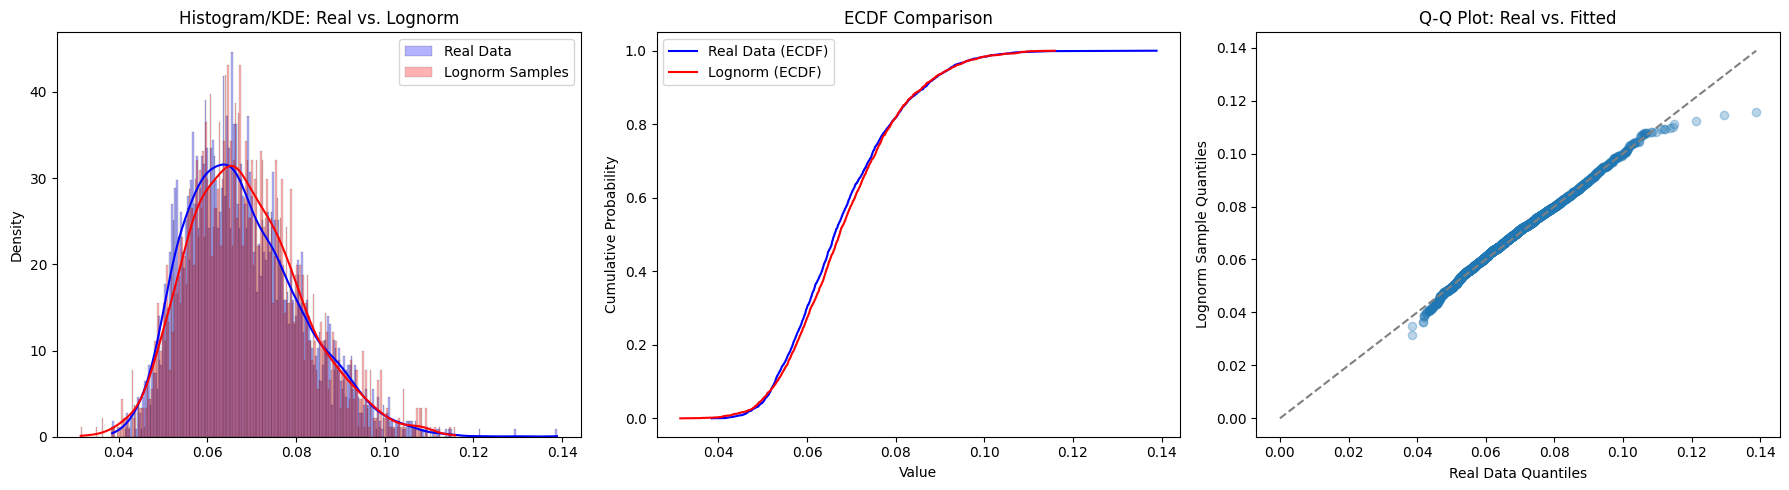




################################################################################
Analyzing qwq_context_inf_fp8_val_fp8 : squad-all_QWQ_context_2000output_inf-fp8_val-fp8.jsonl
Dropped 208 / 1900 items


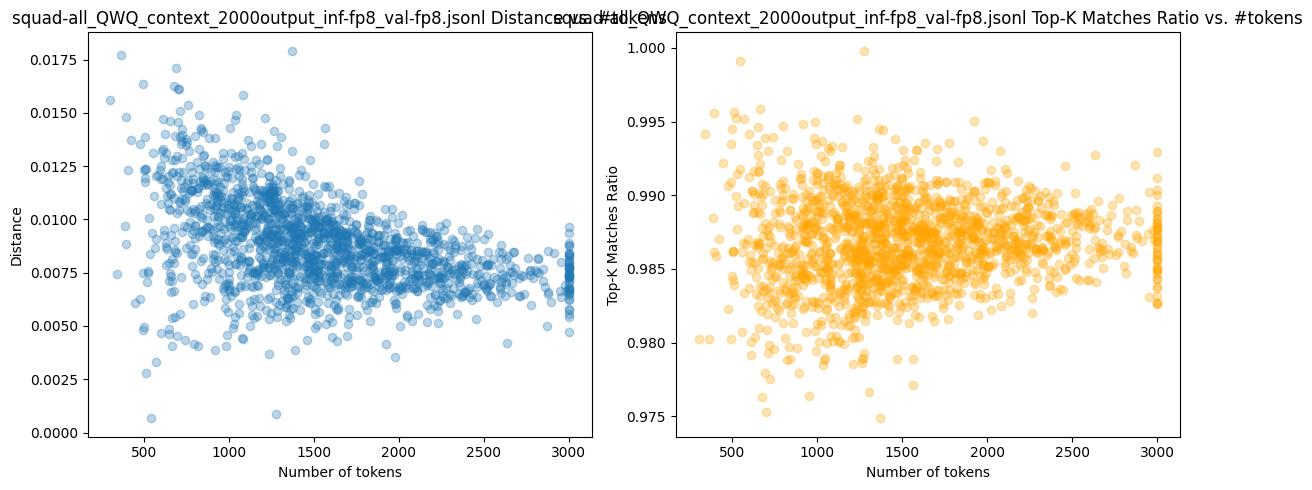


--- DISTANCES DESCRIPTIVE STATISTICS ---
Count: 1692
Min:   0.0007
Max:   0.0179
Mean:  0.0088
Std:   0.0021
Quartiles:
0.25    0.007374
0.50    0.008560
0.75    0.010017
dtype: float64

--- TOP_K_MATCHES_RATIOS DESCRIPTIVE STATISTICS ---
Count: 1692
Min:   0.9749
Max:   0.9998
Mean:  0.9868
Std:   0.0030
Quartiles:
0.25    0.984935
0.50    0.986827
0.75    0.988687
dtype: float64
################################################################################
Fitting normal...
Fitted Normal Params: mu=0.0088, sigma=0.0021
KS test: statistic=0.0502, p-value=0.0004
Fitting gamma...
Fitted Gamma Params: shape=17.3511, loc=0.0000, scale=0.0005
KS test: statistic=0.0330, p-value=0.0493
Fitting lognorm...
Fitted Lognormal Params: shape=0.2498, loc=0.0000, scale=0.0085
KS test: statistic=0.0412, p-value=0.0061
Fitting beta...
Fitted Beta Params: alpha=17.2059, beta=1938.1894, loc=0.0000, scale=1.0000
KS test: statistic=0.0330, p-value=0.0496
#################################################

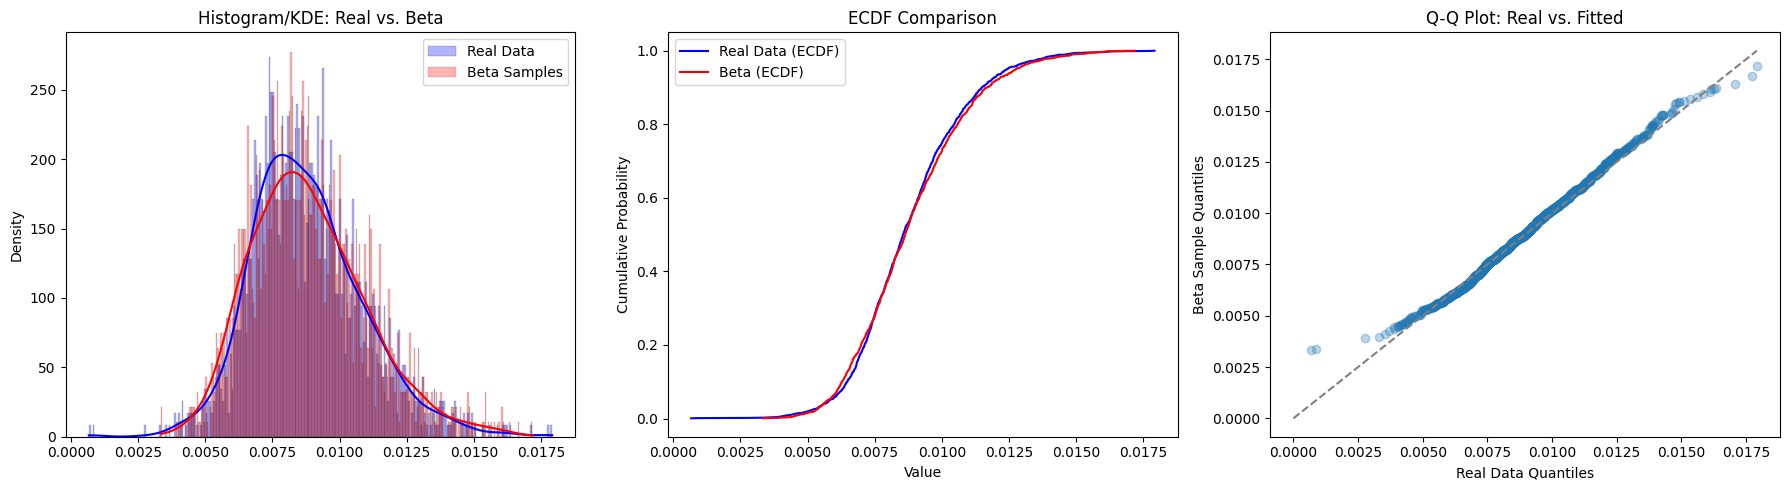




################################################################################
Analyzing qwq_context_inf_int4_val_fp8_UPDATED : squad-all_QWQ_context_2000output_inf-awq-int4_val-fp8_UPDATED.jsonl
Dropped 26 / 500 items


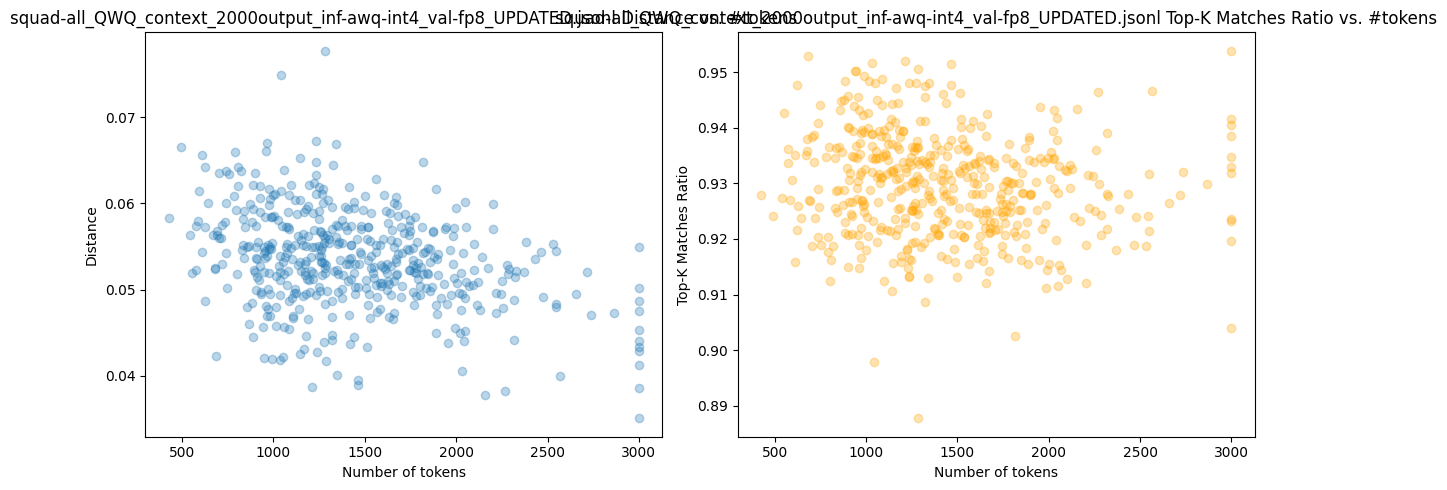


--- DISTANCES DESCRIPTIVE STATISTICS ---
Count: 474
Min:   0.0351
Max:   0.0777
Mean:  0.0535
Std:   0.0057
Quartiles:
0.25    0.050003
0.50    0.053373
0.75    0.057046
dtype: float64

--- TOP_K_MATCHES_RATIOS DESCRIPTIVE STATISTICS ---
Count: 474
Min:   0.8878
Max:   0.9538
Mean:  0.9296
Std:   0.0094
Quartiles:
0.25    0.923071
0.50    0.929905
0.75    0.935572
dtype: float64
################################################################################
Fitting normal...
Fitted Normal Params: mu=0.0535, sigma=0.0057
KS test: statistic=0.0399, p-value=0.4267
Fitting gamma...
Fitted Gamma Params: shape=86.5275, loc=0.0000, scale=0.0006
KS test: statistic=0.0500, p-value=0.1811
Fitting lognorm...
Fitted Lognormal Params: shape=0.1084, loc=0.0000, scale=0.0531
KS test: statistic=0.0570, p-value=0.0888
Fitting beta...
Fitted Beta Params: alpha=81.9907, beta=1451.8135, loc=0.0000, scale=1.0000
KS test: statistic=0.0492, p-value=0.1942
###################################################

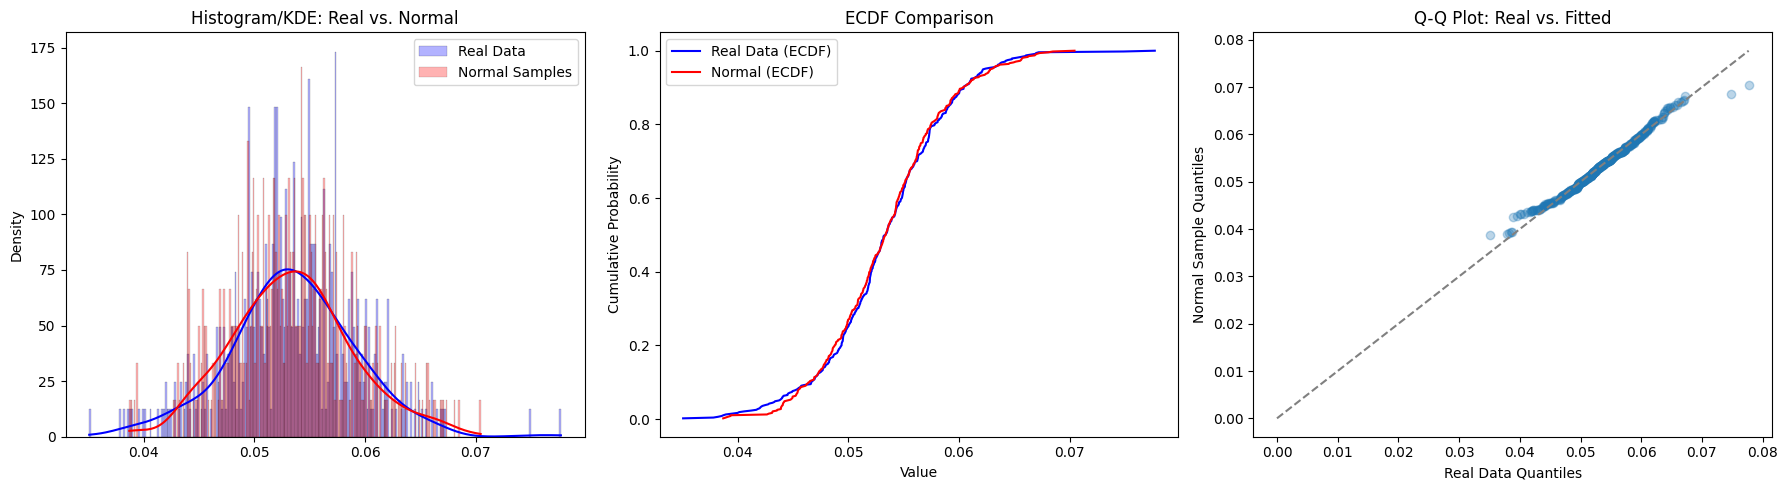




################################################################################
Analyzing qwen8b_fp8_val_fp8 : squad-all_qwen25-7B_fp8_val-fp8.jsonl
Dropped 33 / 2000 items


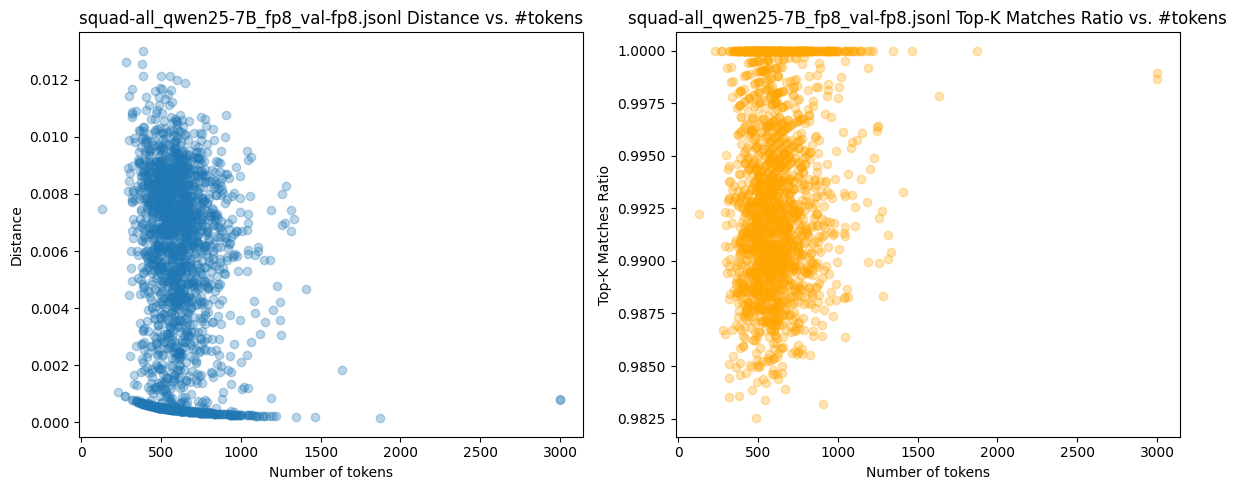


--- DISTANCES DESCRIPTIVE STATISTICS ---
Count: 1967
Min:   0.0001
Max:   0.0130
Mean:  0.0053
Std:   0.0032
Quartiles:
0.25    0.002362
0.50    0.006006
0.75    0.007946
dtype: float64

--- TOP_K_MATCHES_RATIOS DESCRIPTIVE STATISTICS ---
Count: 1967
Min:   0.9825
Max:   1.0000
Mean:  0.9935
Std:   0.0045
Quartiles:
0.25    0.989922
0.50    0.992802
0.75    0.997663
dtype: float64
################################################################################
Fitting normal...
Fitted Normal Params: mu=0.0053, sigma=0.0032
KS test: statistic=0.1093, p-value=0.0000
Fitting gamma...
Fitted Gamma Params: shape=1.3654, loc=0.0000, scale=0.0039
KS test: statistic=0.1839, p-value=0.0000
Fitting lognorm...
Fitted Lognormal Params: shape=1.1389, loc=0.0000, scale=0.0035
KS test: statistic=0.2208, p-value=0.0000
Fitting beta...
Fitted Beta Params: alpha=1.3624, beta=254.9583, loc=0.0000, scale=1.0000
KS test: statistic=0.1836, p-value=0.0000
####################################################

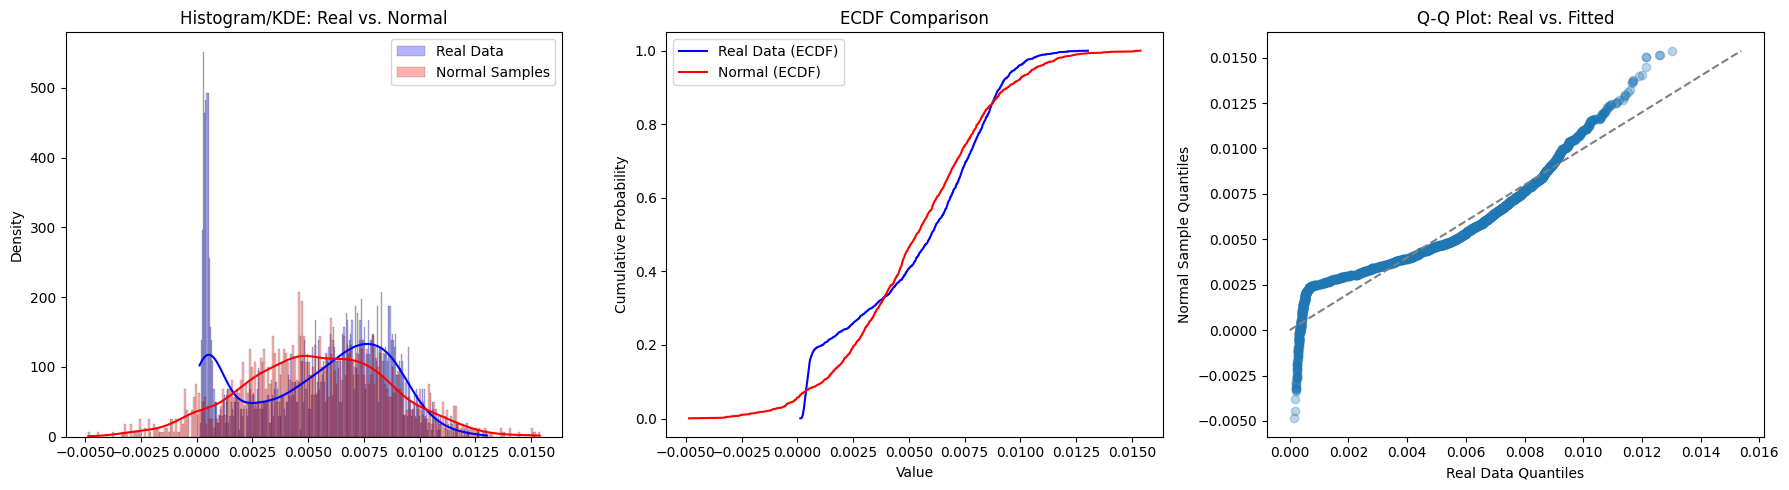




################################################################################
Analyzing qwen8b_int4_val_int4 : squad-all_qwen25-7B_awq-int4_val-fp8.jsonl
Dropped 26 / 2000 items


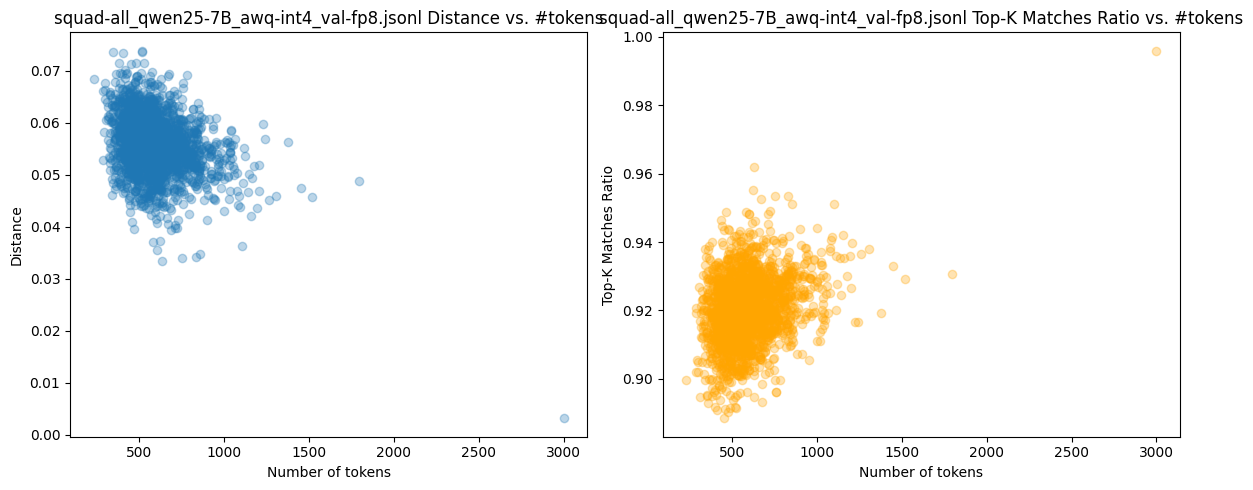


--- DISTANCES DESCRIPTIVE STATISTICS ---
Count: 1974
Min:   0.0032
Max:   0.0738
Mean:  0.0558
Std:   0.0057
Quartiles:
0.25    0.052335
0.50    0.055920
0.75    0.059452
dtype: float64

--- TOP_K_MATCHES_RATIOS DESCRIPTIVE STATISTICS ---
Count: 1974
Min:   0.8885
Max:   0.9959
Mean:  0.9204
Std:   0.0100
Quartiles:
0.25    0.914198
0.50    0.920270
0.75    0.926906
dtype: float64
################################################################################
Fitting normal...
Fitted Normal Params: mu=0.0558, sigma=0.0057
KS test: statistic=0.0245, p-value=0.1835
Fitting gamma...
Fitted Gamma Params: shape=81.4796, loc=0.0000, scale=0.0007
KS test: statistic=0.0483, p-value=0.0002
Fitting lognorm...
Fitted Lognormal Params: shape=0.1212, loc=0.0000, scale=0.0555
KS test: statistic=0.0688, p-value=0.0000
Fitting beta...
Fitted Beta Params: alpha=77.5782, beta=1312.2809, loc=0.0000, scale=1.0000
KS test: statistic=0.0471, p-value=0.0003
#################################################

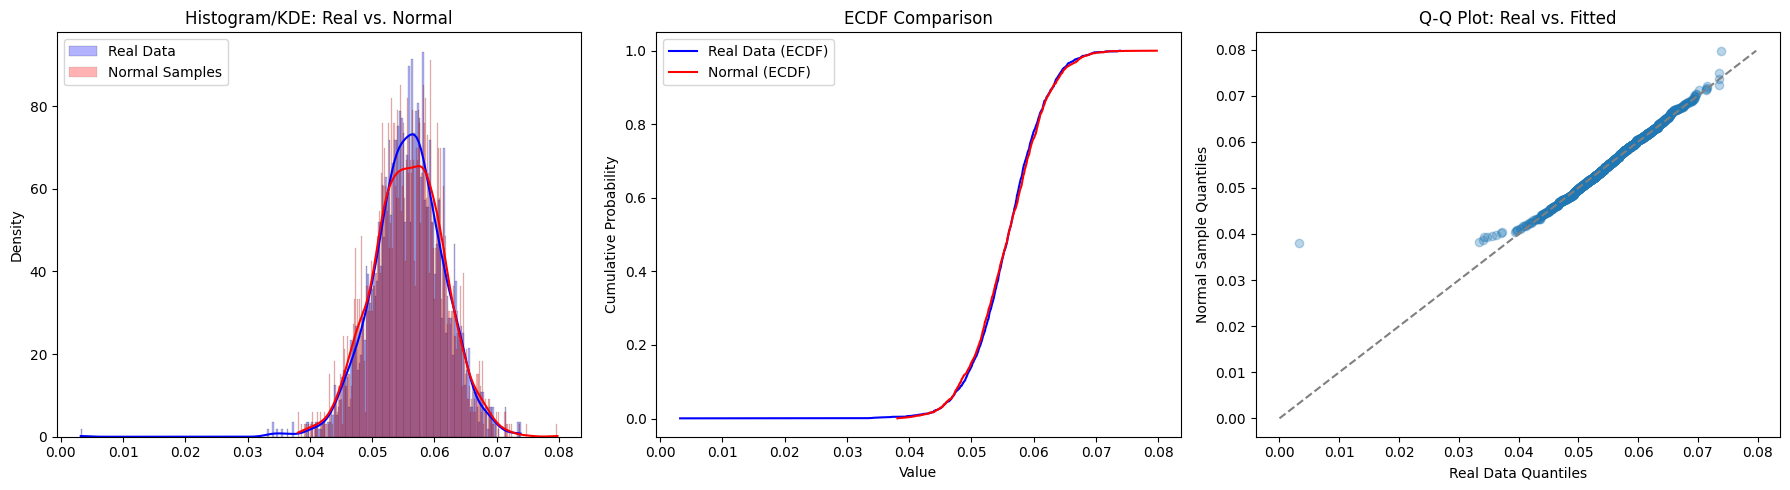

In [15]:
data_path_to_fit = {}
data_path_to_distances = {}

for name, data_path in DATA_PATHS.items():
    print("\n\n")
    print(80*"#")
    print(f"Analyzing {name} : {data_path}")
    items = load_from_jsonl(data_path, n=100000)
    items, distances, top_k_matches_ratios = process_data(items)
    plot_distances_and_matches(items, distances, top_k_matches_ratios, data_path)
    best_fit, fit_results = analyze(distances, top_k_matches_ratios)
    data_path_to_fit[data_path] = best_fit
    data_path_to_distances[data_path] = distances

In [16]:
def classify_data(distances, lower_bound, upper_bound):
    classifications = []
    for d in distances:
        if d < lower_bound:
            classifications.append('accepted')
        elif d > upper_bound:
            classifications.append('fraud')
        else:
            classifications.append('questionable')
    return classifications

Searching optimal bounds: 100%|██████████| 182/182 [00:02<00:00, 67.24it/s]


Optimal Lower Bound: 0.025494
Optimal Upper Bound: 0.026494
Best F1-Score: 0.9803


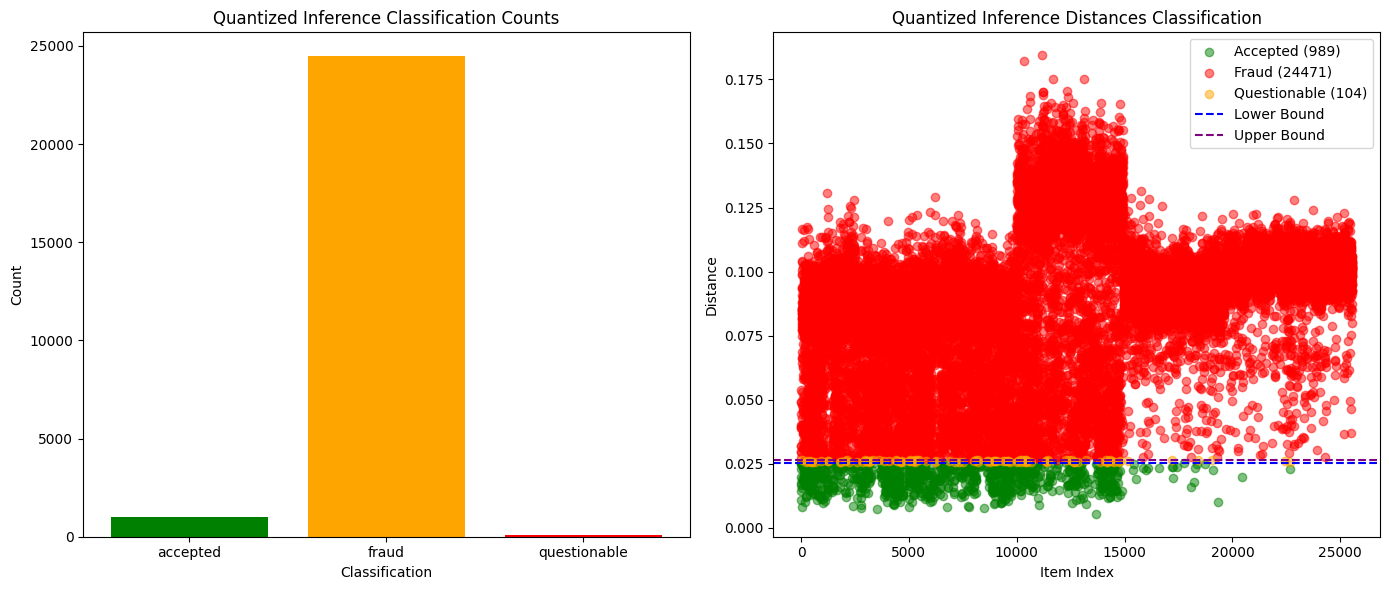

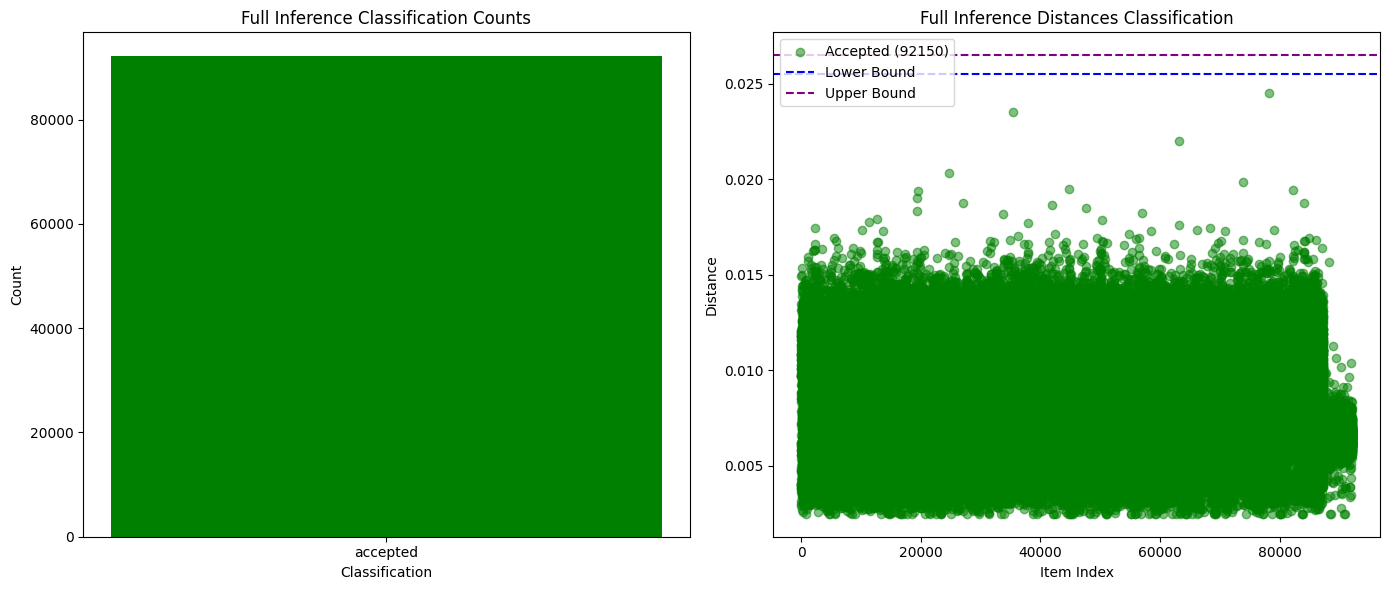

In [17]:
import numpy as np
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm
from joblib import Parallel, delayed

def evaluate_bound(lower, upper_candidates, distances_val, distances_quant):
    if np.any(distances_val > lower):
        return None

    all_distances = np.concatenate([distances_val, distances_quant])
    labels_true = np.array([0] * len(distances_val) + [1] * len(distances_quant))

    best_f1 = -1
    optimal_upper = None
    for upper in upper_candidates:
        labels_pred = np.where(all_distances < lower, 0, 1)
        labels_pred[(all_distances >= lower) & (all_distances <= upper)] = 1
        current_f1 = f1_score(labels_true, labels_pred)
        if current_f1 > best_f1:
            best_f1 = current_f1
            optimal_upper = upper
    return lower, optimal_upper, best_f1


def find_optimal_bounds_parallel(distances_val, distances_quant, step=0.0001, n_jobs=-1):
    all_distances = np.concatenate([distances_val, distances_quant])
    min_dist, max_dist = all_distances.min(), all_distances.max()
    search_space = np.arange(min_dist, max_dist, step)

    results = Parallel(n_jobs=n_jobs)(
        delayed(evaluate_bound)(
            lower,
            search_space[search_space > lower],
            distances_val,
            distances_quant
        )
        for lower in tqdm(search_space, desc="Searching optimal bounds")
    )

    # Remove None results that violate the constraint
    results = [r for r in results if r is not None]

    if not results:
        raise ValueError("No valid bounds found under the constraint that no distances_val exceed the lower bound.")

    optimal_lower, optimal_upper, best_f1 = max(results, key=lambda x: x[2])

    print(f"Optimal Lower Bound: {optimal_lower:.6f}")
    print(f"Optimal Upper Bound: {optimal_upper:.6f}")
    print(f"Best F1-Score: {best_f1:.4f}")

    return optimal_lower, optimal_upper


def plot_classification_results(distances, classifications, lower_bound, upper_bound, title_prefix=""):
    classification_counts = Counter(classifications)

    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.bar(classification_counts.keys(), classification_counts.values(), color=['green', 'orange', 'red'])
    plt.title(f"{title_prefix} Classification Counts")
    plt.xlabel("Classification")
    plt.ylabel("Count")

    plt.subplot(1, 2, 2)
    color_map = {'accepted': 'green', 'questionable': 'orange', 'fraud': 'red'}
    for classification in classification_counts:
        idxs = [i for i, c in enumerate(classifications) if c == classification]
        plt.scatter(
            idxs, [distances[i] for i in idxs],
            c=color_map[classification], alpha=0.5,
            label=f"{classification.capitalize()} ({classification_counts[classification]})"
        )

    plt.axhline(lower_bound, color='blue', linestyle='--', label='Lower Bound')
    plt.axhline(upper_bound, color='purple', linestyle='--', label='Upper Bound')
    plt.title(f"{title_prefix} Distances Classification")
    plt.xlabel("Item Index")
    plt.ylabel("Distance")
    plt.legend()

    plt.tight_layout()
    plt.show()


distances_full = data_path_to_distances['results-squad-llama3-8b-instruct.jsonl']
distances_full_v2 = data_path_to_distances['results-squad-llama3-8b-instruct_v2.jsonl']
distances_full_qwq = data_path_to_distances["squad-all_QWQ_context_2000output_inf-full_val-full.jsonl"]
distances_qwq_fp8 = data_path_to_distances["squad-all_QWQ_context_2000output_inf-fp8_val-fp8.jsonl"]
distances_qwq_int4 = data_path_to_distances["squad-all_QWQ_context_2000output_inf-awq-int4_val-awq-int4.jsonl"]
distances_qwen8b_fp8 = data_path_to_distances["squad-all_qwen25-7B_fp8_val-fp8.jsonl"]
distances_val_llama = distances_full + distances_full_v2


distances_val_int4 = data_path_to_distances['results-squad-llama3-8b-instruct-inf_full-val_awq_int4.jsonl']
distances_inf_int4 = data_path_to_distances['results-squad-llama3-8b-instruct-inf_awq_int4_val_full.jsonl']
distances_inf_int8 = data_path_to_distances['results-squad-llama3-8b-instruct-inf_awq_int8_val_full.jsonl']
distances_inf_int8_long = data_path_to_distances['results-squad-llama3-8b-instruct-inf_awq_int8_val_full_v2.jsonl']
distances_with_context_inf_full_valint8 = data_path_to_distances['squad-all_context_2000output_inf-full_val-int8_first-6000.jsonl']
distances_qwq_context_inf_full_val_fp8 = data_path_to_distances['squad-all_QWQ_context_2000output_inf-full_val-fp8.jsonl']
distances_qwq_inf_int4_val_fp8 = data_path_to_distances["squad-all_QWQ_context_2000output_inf-awq-int4_val-fp8.jsonl"]
distances_qwq_inf_int4_val_fp8_updated = data_path_to_distances['squad-all_QWQ_context_2000output_inf-awq-int4_val-fp8_UPDATED.jsonl']
distances_qwen8b_int4 = data_path_to_distances["squad-all_qwen25-7B_awq-int4_val-fp8.jsonl"]

distances_quant_llama = distances_val_int4 + distances_inf_int4 + distances_inf_int8 + distances_inf_int8_long + distances_with_context_inf_full_valint8

optimal_lower, optimal_upper = find_optimal_bounds_parallel(distances_val_llama, distances_quant_llama, n_jobs=64, step=0.001)

classifications_quant = classify_data(distances_quant_llama, optimal_lower, optimal_upper)
classifications_val = classify_data(distances_val_llama, optimal_lower, optimal_upper)

plot_classification_results(
    distances_quant_llama, classifications_quant, optimal_lower, optimal_upper, title_prefix="Quantized Inference"
)

plot_classification_results(
    distances_val_llama, classifications_val, optimal_lower, optimal_upper, title_prefix="Full Inference"
)

Searching optimal bounds: 100%|██████████| 74/74 [00:00<00:00, 13951.48it/s]


Optimal Lower Bound: 0.013134
Optimal Upper Bound: 0.014134
Best F1-Score: 0.9997


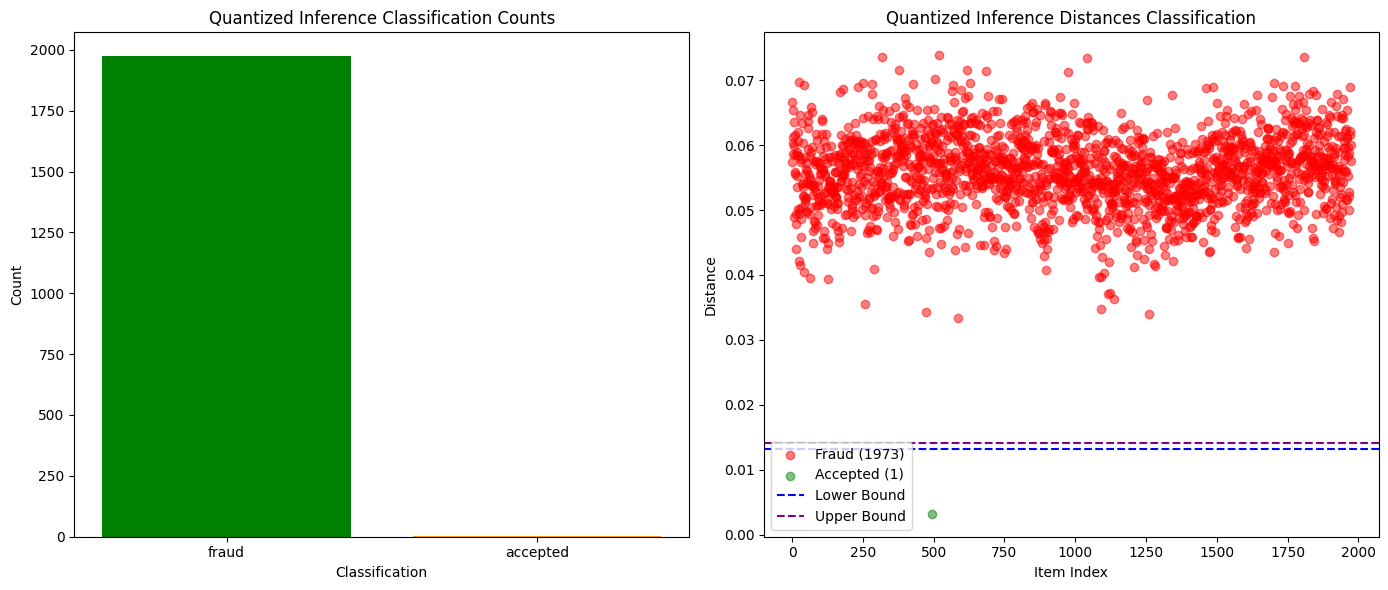

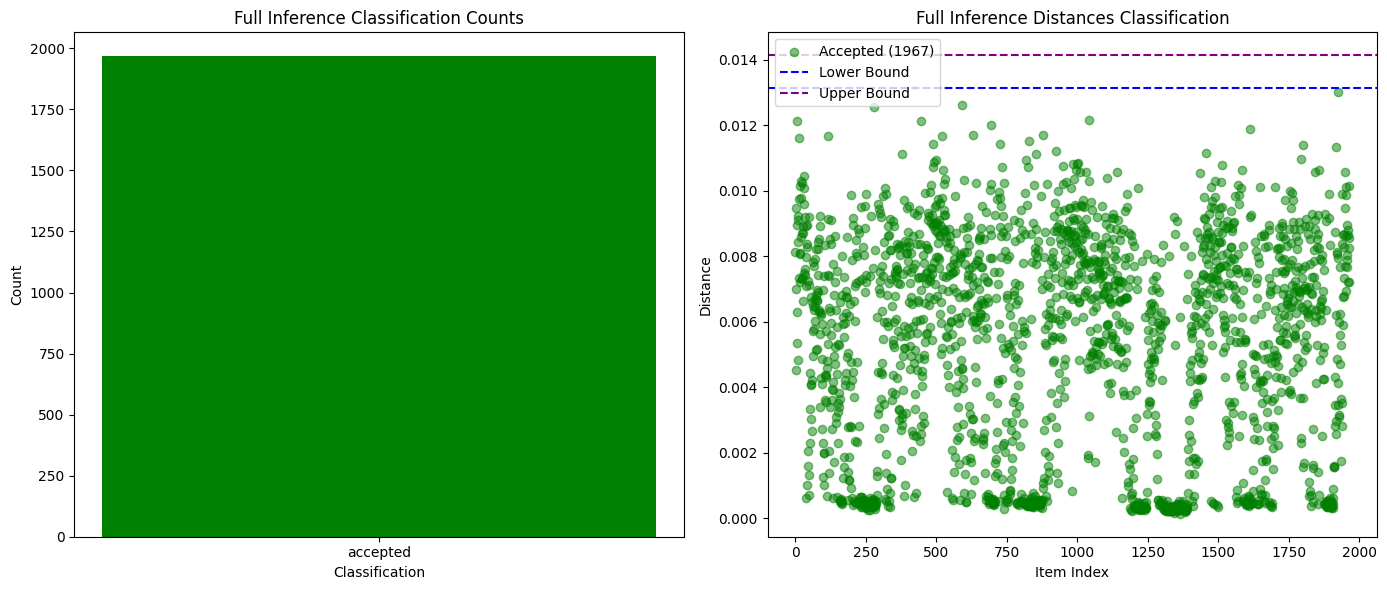

In [18]:
distances_val_qwen = distances_qwen8b_fp8

distances_quant_qwen = distances_qwen8b_int4


optimal_lower, optimal_upper = find_optimal_bounds_parallel(distances_val_qwen, distances_quant_qwen, n_jobs=64, step=0.001)

classifications_quant = classify_data(distances_quant_qwen, optimal_lower, optimal_upper)
classifications_val = classify_data(distances_val_qwen, optimal_lower, optimal_upper)

plot_classification_results(
    distances_quant_qwen, classifications_quant, optimal_lower, optimal_upper, title_prefix="Quantized Inference"
)

plot_classification_results(
    distances_val_qwen, classifications_val, optimal_lower, optimal_upper, title_prefix="Full Inference"
)

Searching optimal bounds: 100%|██████████| 45/45 [00:00<00:00, 54819.54it/s]

Optimal Lower Bound: 0.016076
Optimal Upper Bound: 0.017076
Best F1-Score: 0.9978


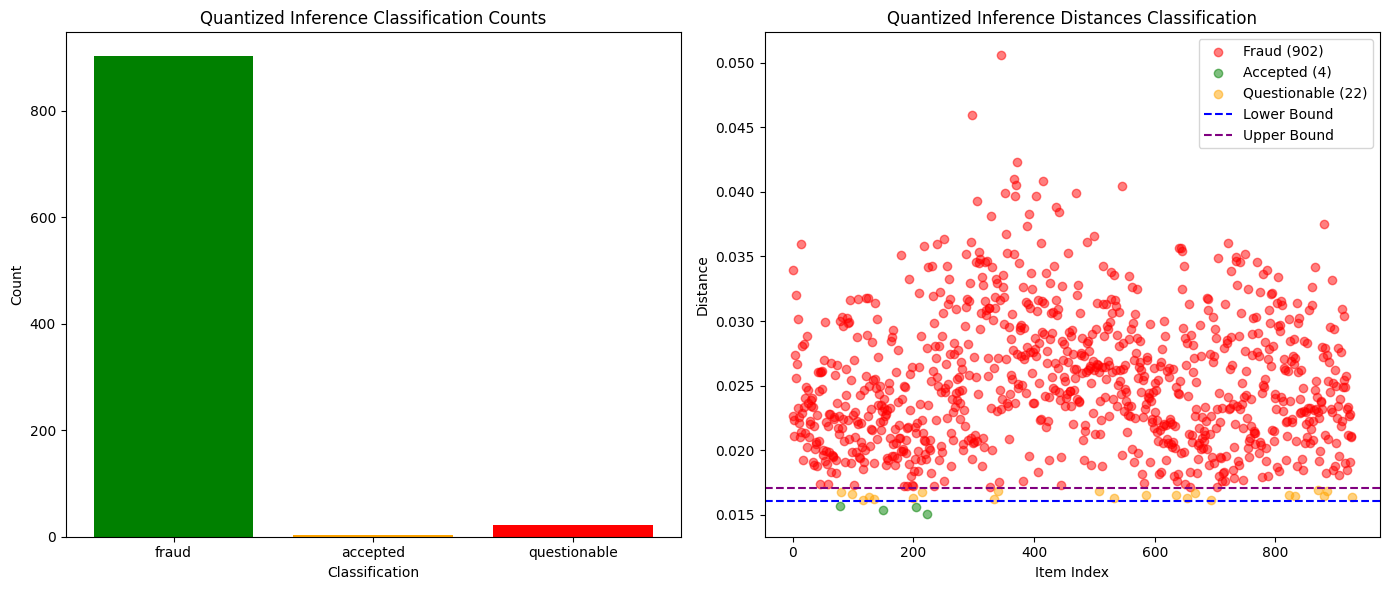

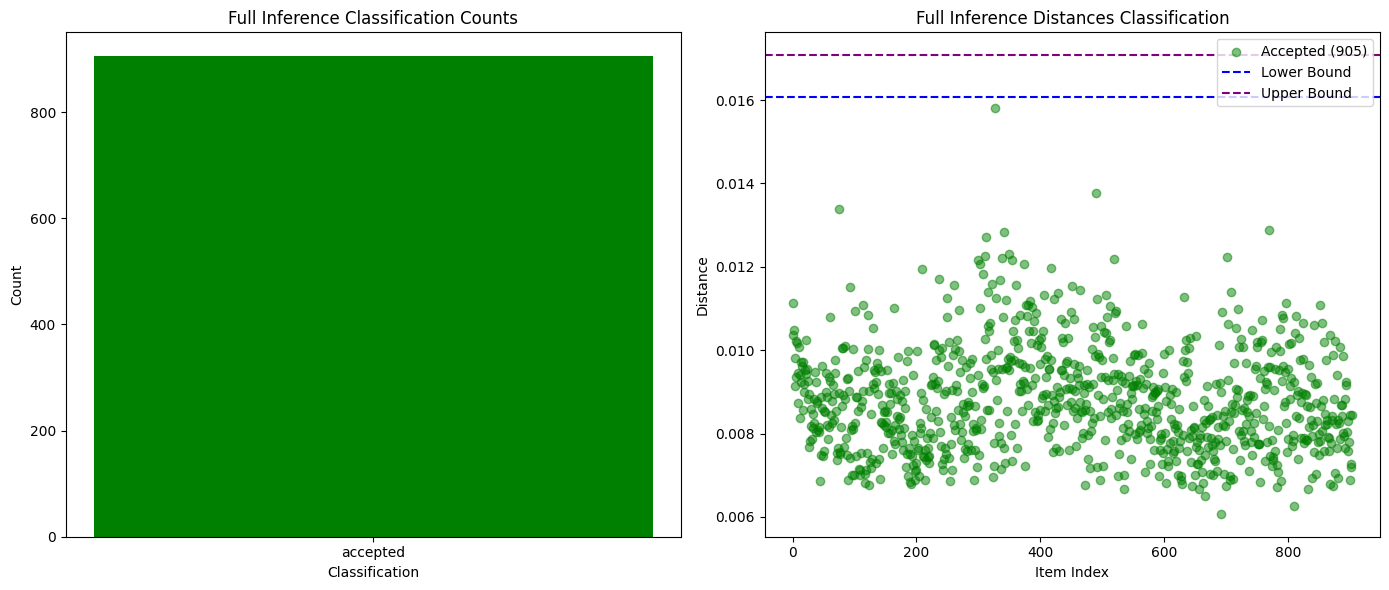

In [19]:
distances_val_qwq = distances_full_qwq

distances_quant_qwq = distances_qwq_context_inf_full_val_fp8


optimal_lower, optimal_upper = find_optimal_bounds_parallel(distances_val_qwq, distances_quant_qwq, n_jobs=64, step=0.001)

classifications_quant = classify_data(distances_quant_qwq, optimal_lower, optimal_upper)
classifications_val = classify_data(distances_val_qwq, optimal_lower, optimal_upper)

plot_classification_results(
    distances_quant_qwq, classifications_quant, optimal_lower, optimal_upper, title_prefix="Quantized Inference"
)

plot_classification_results(
    distances_val_qwq, classifications_val, optimal_lower, optimal_upper, title_prefix="Full Inference"
)

Searching optimal bounds: 100%|██████████| 74/74 [00:00<00:00, 22706.74it/s]

Optimal Lower Bound: 0.013134
Optimal Upper Bound: 0.014134
Best F1-Score: 0.9997


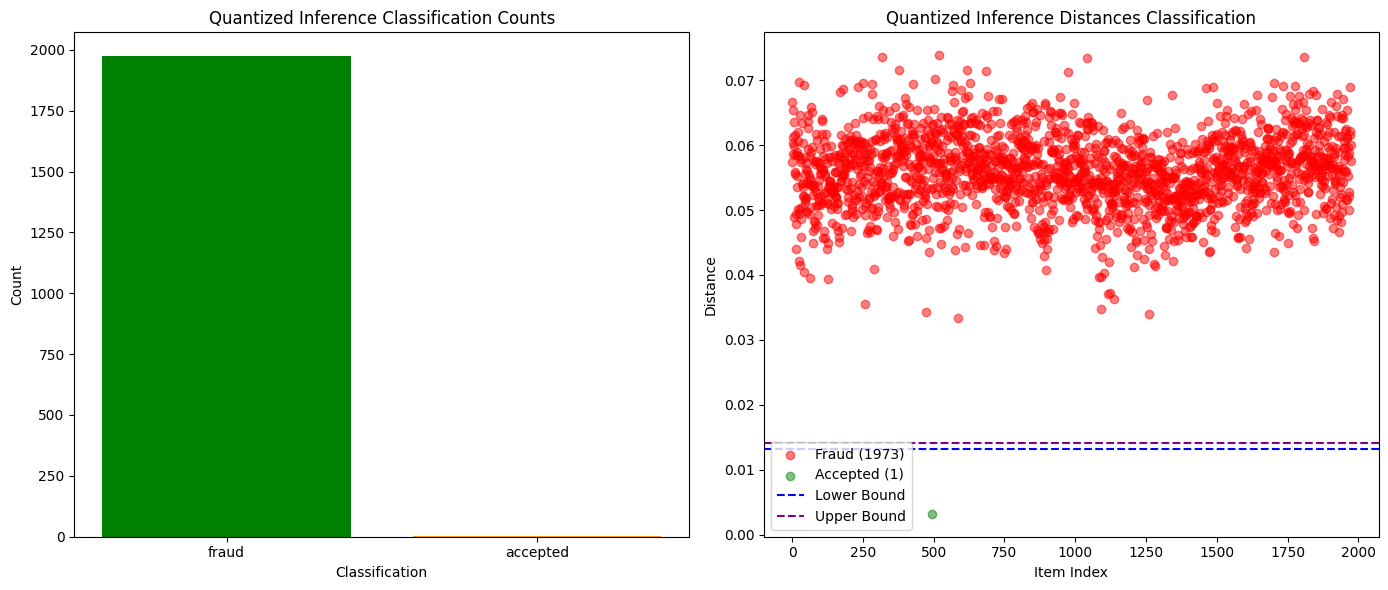

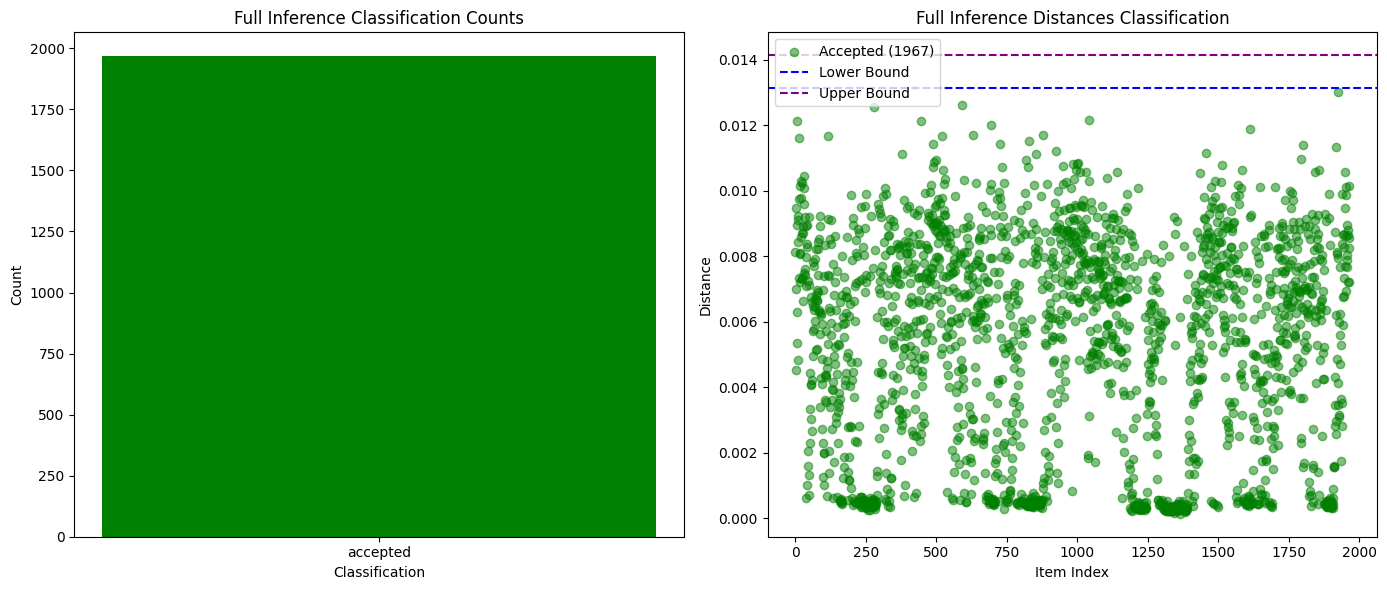

In [20]:
distances_val_qwen8b = distances_qwen8b_fp8

distances_quant_qwen8b = distances_qwen8b_int4


optimal_lower, optimal_upper = find_optimal_bounds_parallel(distances_val_qwen8b, distances_quant_qwen8b, n_jobs=64, step=0.001)

classifications_quant = classify_data(distances_quant_qwen8b, optimal_lower, optimal_upper)
classifications_val = classify_data(distances_val_qwen8b, optimal_lower, optimal_upper)

plot_classification_results(
    distances_quant_qwen8b, classifications_quant, optimal_lower, optimal_upper, title_prefix="Quantized Inference"
)

plot_classification_results(
    distances_val_qwen8b, classifications_val, optimal_lower, optimal_upper, title_prefix="Full Inference"
)

Searching optimal bounds: 100%|██████████| 139/139 [00:00<00:00, 9254.83it/s]


Optimal Lower Bound: 0.018666
Optimal Upper Bound: 0.019666
Best F1-Score: 1.0000


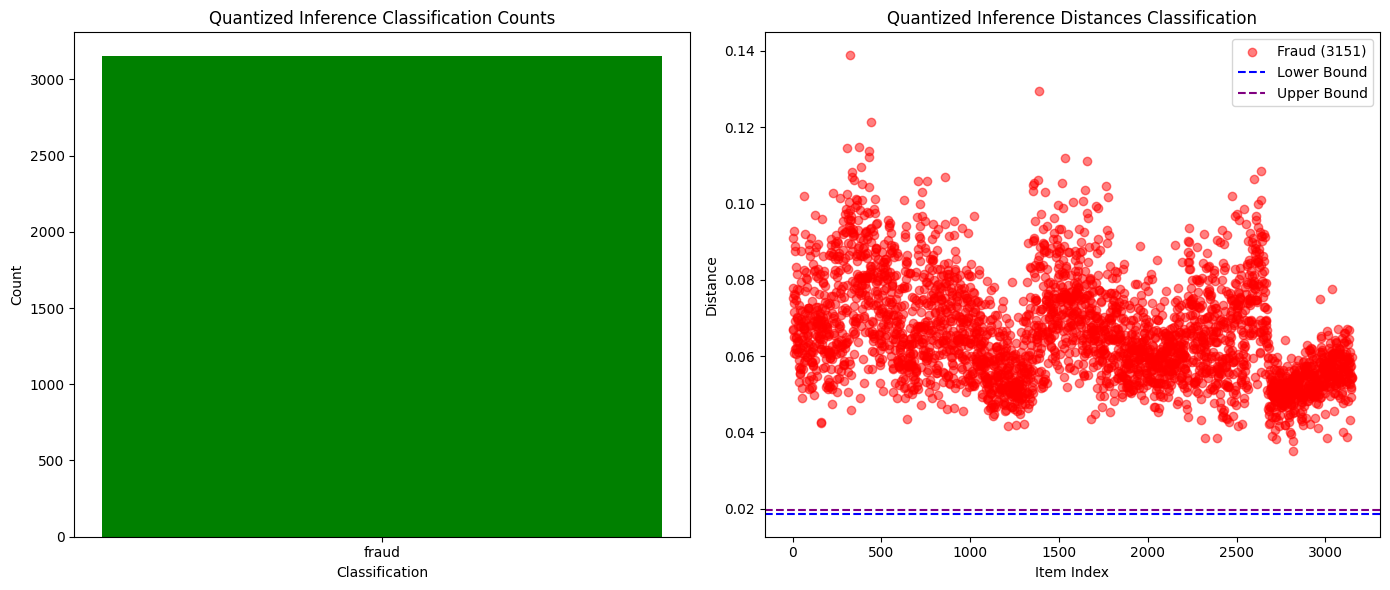

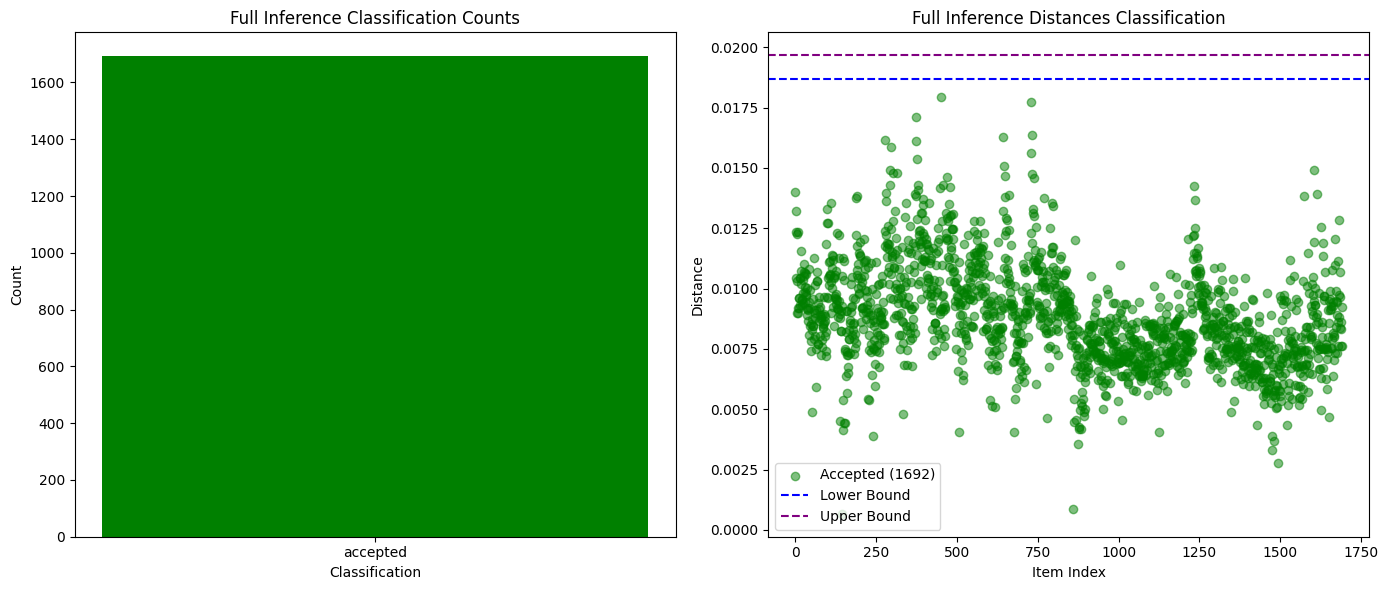

In [21]:
distances_val_qwq_fp8 = distances_qwq_fp8

distances_quant_qwq_fp8 = distances_qwq_inf_int4_val_fp8 + distances_qwq_inf_int4_val_fp8_updated


optimal_lower, optimal_upper = find_optimal_bounds_parallel(distances_val_qwq_fp8, distances_quant_qwq_fp8, n_jobs=64, step=0.001)

classifications_quant = classify_data(distances_quant_qwq_fp8, optimal_lower, optimal_upper)
classifications_val = classify_data(distances_val_qwq_fp8, optimal_lower, optimal_upper)

plot_classification_results(
    distances_quant_qwq_fp8, classifications_quant, optimal_lower, optimal_upper, title_prefix="Quantized Inference"
)

plot_classification_results(
    distances_val_qwq_fp8, classifications_val, optimal_lower, optimal_upper, title_prefix="Full Inference"
)

Searching optimal bounds: 100%|██████████| 184/184 [00:00<00:00, 12375.55it/s]


Optimal Lower Bound: 0.024666
Optimal Upper Bound: 0.025666
Best F1-Score: 0.9763


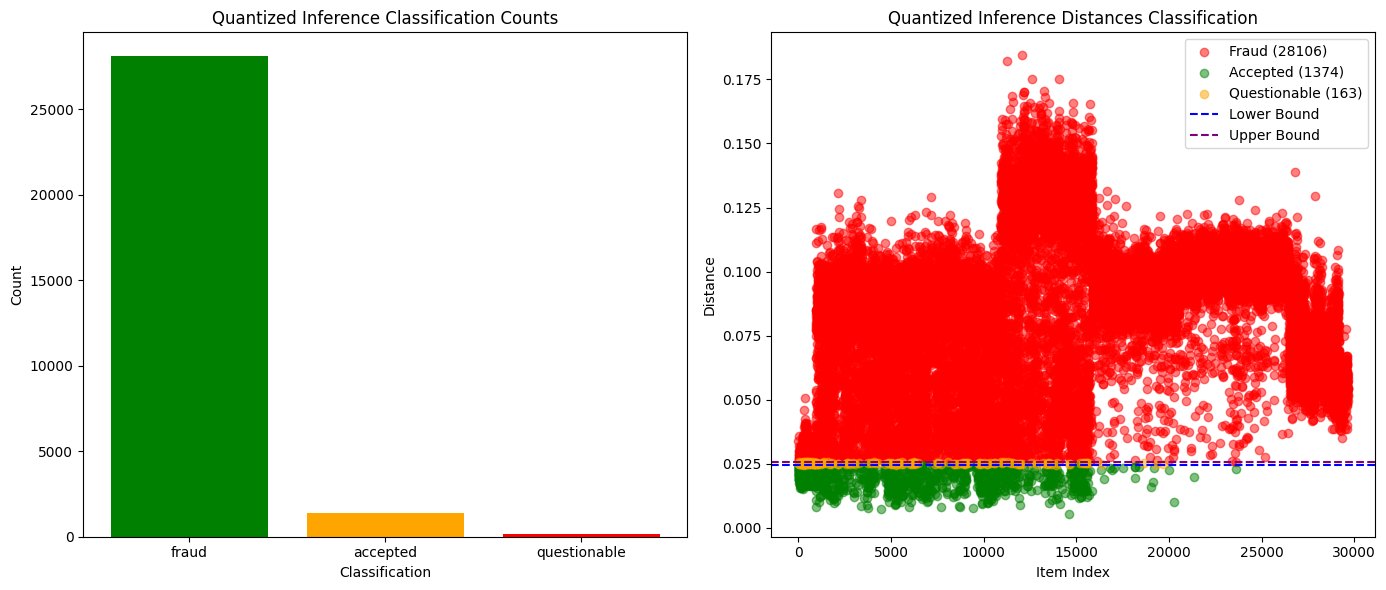

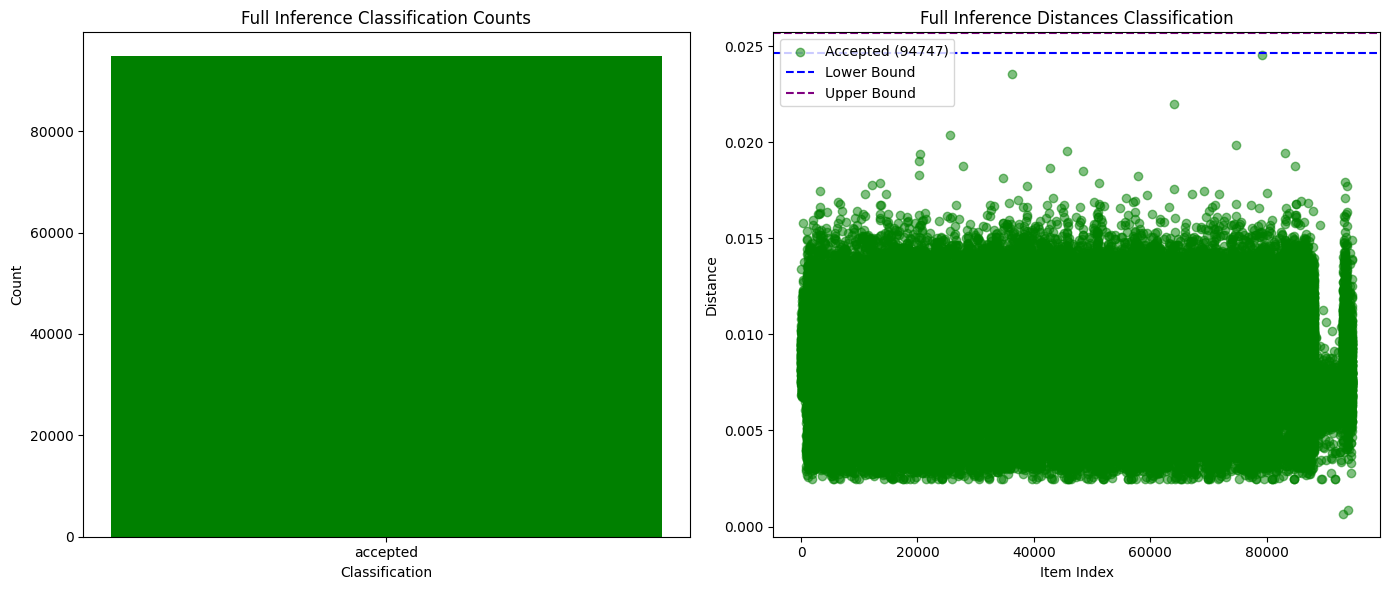

In [22]:
distances_val_all = distances_val_qwq + distances_val_llama + distances_val_qwq_fp8
distances_quant_all = distances_quant_qwq + distances_quant_llama + distances_quant_qwq_fp8

optimal_lower, optimal_upper = find_optimal_bounds_parallel(
    distances_val_all,
    distances_quant_all,
    n_jobs=64,
    step=0.001
)

classifications_quant = classify_data(distances_quant_all, optimal_lower, optimal_upper)
classifications_val = classify_data(distances_val_all, optimal_lower, optimal_upper)

plot_classification_results(
    distances_quant_all, classifications_quant, optimal_lower, optimal_upper, title_prefix="Quantized Inference"
)

plot_classification_results(
    distances_val_all, classifications_val, optimal_lower, optimal_upper, title_prefix="Full Inference"
)